# Prep for Analysis

## Import Statements

In [1]:
# Import statements

# General
import pandas as pd
import re
import os
import json
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
import numpy as np 
import seaborn as sns

# Preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.corpus import stopwords
from sklearn.preprocessing import StandardScaler
from scipy import sparse
from scipy.sparse import hstack, csr_matrix, save_npz


# Clustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import LatentDirichletAllocation, PCA

## Load in Data

In [2]:
df = pd.read_csv("data/cleaned_text_data.csv")

## Functions

In [3]:
def plot_numeric_distributions(df, numeric_cols, program_name="Medicaid"):
    """
    Plots histograms of numeric columns for a given program (Medicaid or Medicare)
    after outlier removal.
    """
    n_cols = 2
    n_rows = (len(numeric_cols) + 1) // n_cols
    plt.figure(figsize=(14, 6 * n_rows))
    
    for i, col in enumerate(numeric_cols):
        plt.subplot(n_rows, n_cols, i + 1)
        sns.histplot(df[col], bins=30, kde=True, color='skyblue')
        plt.title(f"{program_name}: Distribution of {col.replace('_', ' ').title()}", fontsize=18)
        plt.xlabel(col.replace('_', ' ').title(), fontsize=14)
        plt.ylabel("Number of Posts", fontsize=14)
    
    plt.tight_layout()
    filename = f"figures/{program_name.lower()}_numeric_distributions.png"
    plt.savefig(filename, dpi=300)
    plt.show()
    print(f"Figure saved as {filename}")


In [4]:
def remove_outliers(df, numeric_cols, method='iqr', threshold=1.5):
    df_clean = df.copy()
    outlier_mask = pd.Series(False, index=df.index)
    
    for col in numeric_cols:
        if method == 'iqr':
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            mask = (df[col] < (Q1 - threshold*IQR)) | (df[col] > (Q3 + threshold*IQR))
        elif method == 'zscore':
            mean = df[col].mean()
            std = df[col].std()
            mask = np.abs((df[col] - mean) / std) > threshold
        else:
            raise ValueError("method must be 'iqr' or 'zscore'")
        
        outlier_mask = outlier_mask | mask  # mark if any column is an outlier
    
    removed_indices = df_clean.index[outlier_mask]
    df_clean = df_clean.loc[~outlier_mask].reset_index(drop=True)
    
    print(f"Removed {len(removed_indices)} outlier posts ({len(removed_indices)/len(df)*100:.2f}%)")
    
    return df_clean, removed_indices

In [5]:
# Load English stopwords
stop_words = set(stopwords.words('english'))

In [6]:
# Basic text cleaning function
def clean_text(text):
    """
    Clean text while KEEPING contractions.
    - Lowercasing
    - Removing URLs
    - Removing punctuation except apostrophes inside words
    - Removing numbers
    - Removing stopwords
    - Removing extra whitespace
    """
    text = str(text).lower()

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)

    # Remove numbers
    text = re.sub(r'\d+', ' ', text)

    # Remove punctuation EXCEPT apostrophes inside words
    # Keeps: can't, I've, don't
    text = re.sub(r"[^\w\s']|(?<![a-z])'|'(?![a-z])", " ", text)

    # Tokenize
    tokens = text.split()

    # Remove stopwords **but keep contractions**
    cleaned_tokens = [t for t in tokens if t not in stop_words]

    # Rejoin & clean whitespace
    text = ' '.join(cleaned_tokens)
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [7]:
# Columns to check for outliers
numeric_cols = ['score', 'num_comments', 'text_length', 'word_count']

In [8]:
def kmeans_evaluation(X, k_range=range(2,11)):
    sse = []
    silhouette_scores = []

    for k in k_range:
        km = KMeans(n_clusters=k, random_state=42, n_init=10)
        km.fit(X)
        sse.append(km.inertia_)
        
        if k > 1:
            score = silhouette_score(X, km.labels_)
            silhouette_scores.append(score)
        else:
            silhouette_scores.append(None)
    
    # Plot SSE and Silhouette
    plt.figure(figsize=(12,5))
    
    plt.subplot(1,2,1)
    plt.plot(list(k_range), sse, marker='o')
    plt.xlabel("Number of Clusters (k)")
    plt.ylabel("SSE (Inertia)")
    plt.title("KMeans: Elbow Method")
    
    plt.subplot(1,2,2)
    plt.plot(list(k_range), silhouette_scores, marker='o', color='orange')
    plt.xlabel("Number of Clusters (k)")
    plt.ylabel("Silhouette Score")
    plt.title("KMeans: Silhouette Scores")
    
    plt.tight_layout()
    plt.show()
    
    return pd.DataFrame({
        "k": list(k_range),
        "SSE": sse,
        "Silhouette": silhouette_scores
    })

In [9]:
def get_top_terms_per_cluster(X_tfidf, labels, feature_names, top_n=15):
    cluster_terms = {}
    for cluster in np.unique(labels):
        # Get indices of documents in this cluster
        cluster_idx = np.where(labels == cluster)[0]
        # Mean TF-IDF for each term in this cluster
        mean_tfidf = X_tfidf[cluster_idx].mean(axis=0)
        # Get top N terms
        top_idx = mean_tfidf.argsort()[::-1][:top_n]
        top_words = [(feature_names[i], mean_tfidf[i]) for i in top_idx]
        cluster_terms[cluster] = top_words
    return cluster_terms

In [10]:
def cluster_report(df, X_tfidf, tfidf_features, numeric_features, top_n=15):
    report = {}
    
    for cluster in sorted(df['cluster'].unique()):
        print(f"\n===== Cluster {cluster} =====")
        
        # Get positions of docs in this cluster
        cluster_pos = df.index[df['cluster']==cluster].tolist()
        n_posts = len(cluster_pos)
        print(f"Number of posts: {n_posts}")
        
        # Top TF-IDF terms
        mean_tfidf = X_tfidf[cluster_pos].mean(axis=0)
        top_idx = mean_tfidf.argsort()[::-1][:top_n]
        top_words = [(tfidf_features[i], mean_tfidf[i]) for i in top_idx]
        print("\nTop TF-IDF terms:")
        for term, score in top_words:
            print(f"{term} ({score:.4f})")
        
        # Numeric feature summary
        print("\nNumeric feature summary:")
        print(df.loc[cluster_pos, numeric_features].describe())
        
        # Numeric feature histograms
        import matplotlib.pyplot as plt
        import seaborn as sns
        plt.figure(figsize=(12,4))
        for i, col in enumerate(numeric_features):
            plt.subplot(1, len(numeric_features), i+1)
            sns.histplot(df.loc[cluster_pos, col], kde=True, bins=20)
            plt.title(f"{col} (Cluster {cluster})")
        plt.tight_layout()
        plt.show()
        
        # Store for reference
        report[cluster] = {
            'n_posts': n_posts,
            'top_terms': top_words,
            'numeric_summary': df.loc[cluster_pos, numeric_features].describe()
        }
    
    return report


In [11]:
def print_top_words(model, feature_names, n_top_words=15):
    for topic_idx, topic in enumerate(model.components_):
        top_indices = topic.argsort()[::-1][:n_top_words]
        top_words = [feature_names[i] for i in top_indices]
        top_weights = topic[top_indices]
        print(f"===== Topic {topic_idx} =====")
        for word, weight in zip(top_words, top_weights):
            print(f"{word} ({weight:.4f})")
        print("\n")

# Medicaid Subreddit

In [12]:
df_medicaid = df[df['subreddit'] == 'medicaid'].copy()

In [13]:
len(df_medicaid)

1019

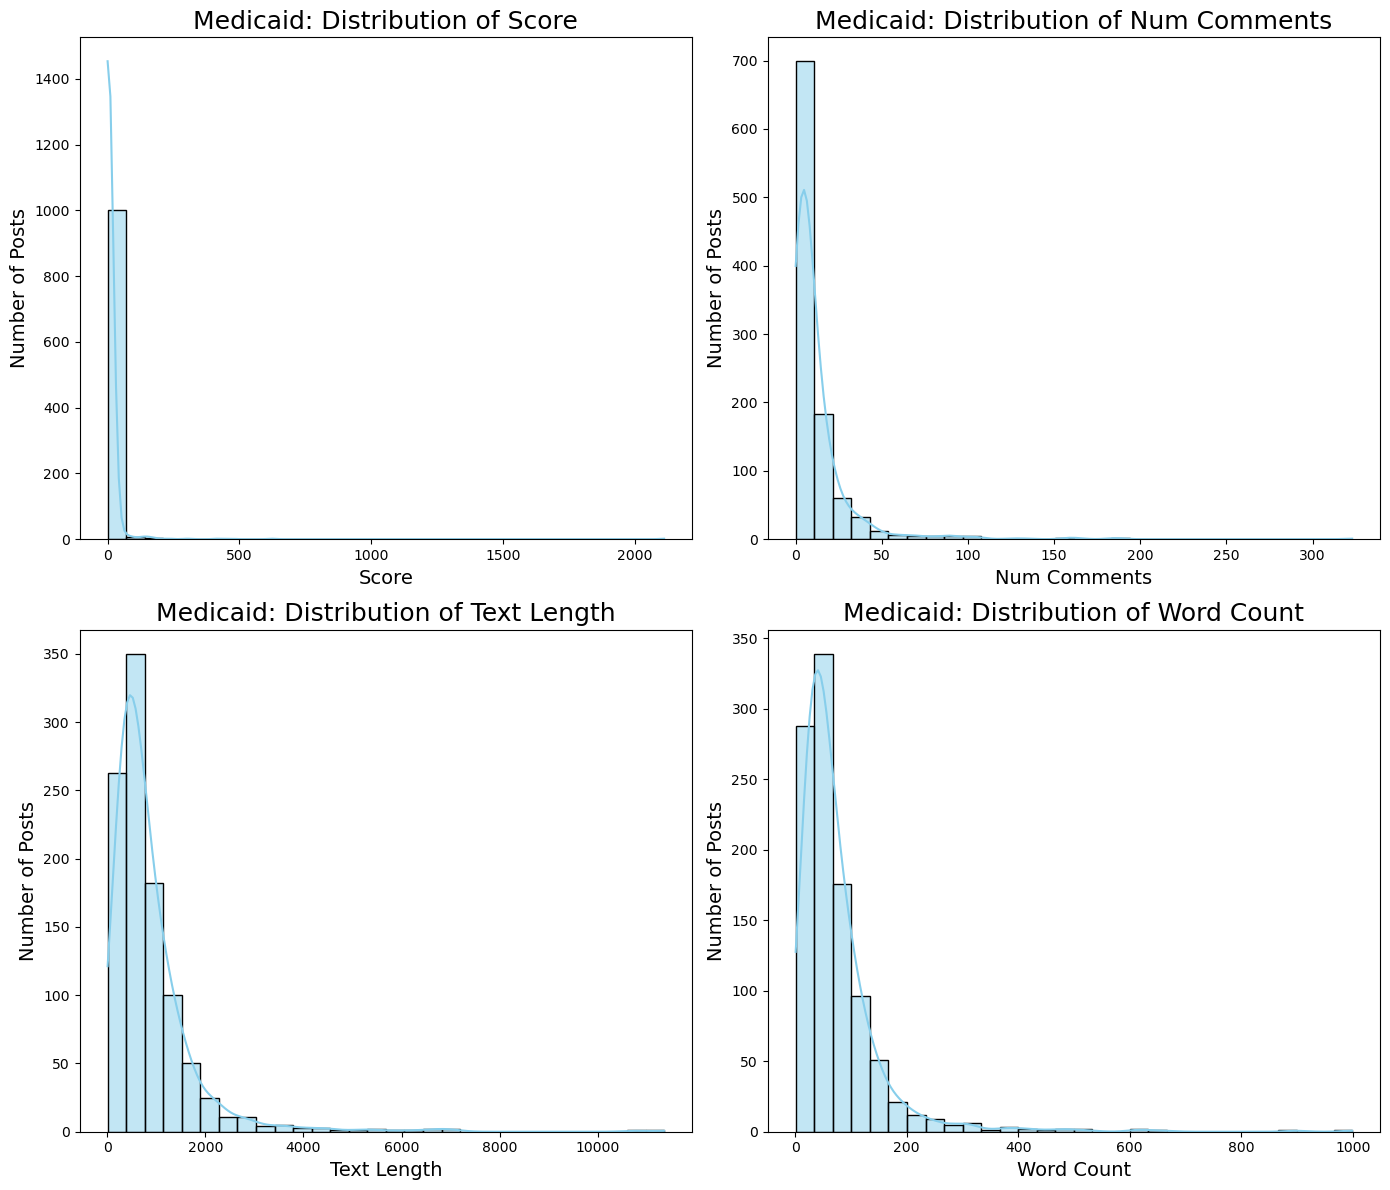

Figure saved as figures/medicaid_numeric_distributions.png


In [14]:
# Example usage for Medicaid
plot_numeric_distributions(df_medicaid, numeric_cols, program_name="Medicaid")

## Remove Outliers

In [15]:
# Remove outliers using IQR method
df_medicaid, removed_idx = remove_outliers(df_medicaid, numeric_cols, method='iqr', threshold=1.5)

# Summary after removal
print(df_medicaid[numeric_cols].describe())

Removed 199 outlier posts (19.53%)
            score  num_comments  text_length  word_count
count  820.000000    820.000000   820.000000  820.000000
mean     1.871951      6.951220   681.890244   58.281707
std      1.653632      6.319732   435.618279   37.107999
min      0.000000      0.000000    10.000000    1.000000
25%      1.000000      2.000000   342.750000   30.000000
50%      1.000000      5.000000   570.500000   48.000000
75%      3.000000     10.000000   949.500000   82.000000
max      7.000000     30.000000  2116.000000  177.000000


## Text Preprocessing

In [16]:
# Apply cleaning
df_medicaid['clean_text'] = df_medicaid['text'].apply(clean_text)

In order to determine the cutoff for `max_df` in our TF-IDF vectorizer, we will investigate the proportion of documents that each token appears in. We will set a baseline `min_df = 10` to focus on words that appear multiple times and are not too specific to a very limited number of posts

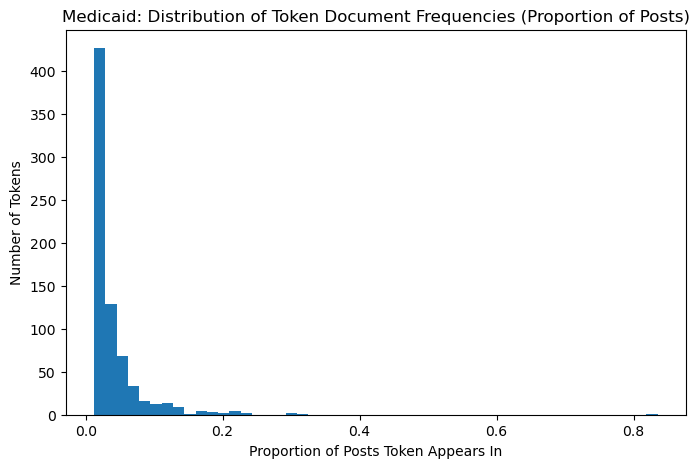

In [17]:
# Plot of token-document frequencies 
texts_medicaid = df_medicaid['clean_text'].tolist()

# Use CountVectorizer for raw term counts (no TF-IDF)
count_vect = CountVectorizer(stop_words='english', min_df=10)
X_counts_medicaid = count_vect.fit_transform(texts_medicaid)

# Compute document frequency for each token
doc_freq_medicaid = (X_counts_medicaid > 0).sum(axis=0).A1  # number of posts each token appears in
num_posts_medicaid = len(texts_medicaid)

# Convert to proportion of posts (0–1)
df_prop_medicaid = doc_freq_medicaid / num_posts_medicaid

plt.figure(figsize=(8,5))
plt.hist(df_prop_medicaid, bins=50)
plt.title("Medicaid: Distribution of Token Document Frequencies (Proportion of Posts)")
plt.xlabel("Proportion of Posts Token Appears In")
plt.ylabel("Number of Tokens")
plt.show()

Based on the above plot, we will exclude all words appearing in more than 10% of posts.

In [18]:
medicaid_vectorizer = TfidfVectorizer(
    stop_words='english',   # generic English stopwords
    min_df=10,              # word must appear in at least 10 posts
    max_df=0.10,            # remove words appearing in >10% of posts
    ngram_range=(1, 2),     # <-- include unigrams + bigrams
    norm='l2'               # normalize vectors
)

In [19]:
tfidf_matrix_medicaid = medicaid_vectorizer.fit_transform(df_medicaid['clean_text'])

### Preprocessing Evaluation

In [20]:
features_medicaid = medicaid_vectorizer.get_feature_names_out()

In [21]:
# 3. Check preprocessing choices
print("Number of posts:", df_medicaid.shape[0])
print("Number of features:", tfidf_matrix_medicaid.shape[1])
print("Sample features:", features_medicaid[:20])

Number of posts: 820
Number of features: 773
Sample features: ['aca' 'accept' 'accept medicaid' 'accepted' 'accepts' 'access'
 'according' 'account' 'accounts' 'active' 'actual' 'actually' 'add'
 'added' 'additional' 'address' 'adult' 'adults' 'advance' 'advantage']


In [22]:
# Check sparsity 
medicaid_sparsity = 1.0 - (tfidf_matrix_medicaid.nnz / float(tfidf_matrix_medicaid.shape[0] * tfidf_matrix_medicaid.shape[1]))
print("Sparsity:", medicaid_sparsity)

Sparsity: 0.9716577793203547


In [23]:
# Examine most frequent words 
idf_medicaid = medicaid_vectorizer.idf_

idf_df_medicaid = pd.DataFrame({'token': features_medicaid, 'idf': idf_medicaid})
print(idf_df_medicaid.sort_values('idf').head(20))

                token       idf
37        application  3.291683
255           getting  3.316074
20             advice  3.328496
321       information  3.353814
24                ago  3.353814
624            social  3.393035
746              week  3.406458
349            letter  3.420064
429               mom  3.462028
758           working  3.462028
727               use  3.476417
743               way  3.491015
154             cover  3.491015
105              case  3.491015
329            issues  3.505830
155           covered  3.505830
201       eligibility  3.520868
279  health insurance  3.520868
556           receive  3.536136
94             called  3.536136


In [24]:
# Look at least frequent words
idf_df_medicaid.sort_values('idf', ascending=False).head(20)

,token,idf
772,zero,5.312628
244,food stamps,5.312628
547,qualifying,5.312628
542,putting,5.312628
538,prove,5.312628
671,switched,5.312628
676,talking,5.312628
530,private insurance,5.312628
218,example,5.312628
73,based income,5.312628


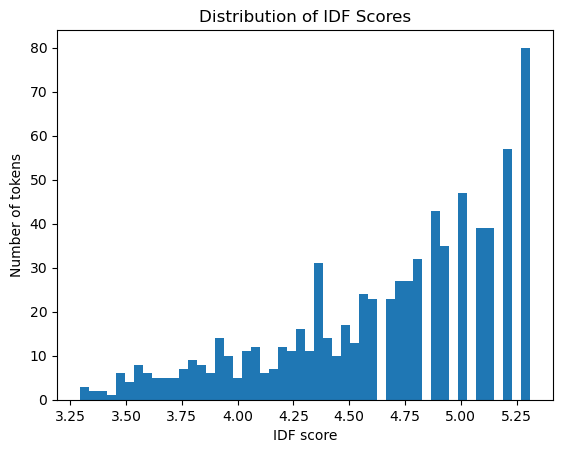

In [25]:
# IDF distribution 
plt.hist(idf_medicaid, bins=50)
plt.xlabel("IDF score")
plt.ylabel("Number of tokens")
plt.title("Distribution of IDF Scores")
plt.show()

In [26]:
# Inspect bigrams from original text
medicaid_counts = Counter()

# Count n-grams in original text
for text in df_medicaid['clean_text']:
    tokens = text.split()
    for w in zip(tokens, tokens[1:]):
        medicaid_counts[" ".join(w)] += 1

print(medicaid_counts.most_common(20))

[('social security', 86), ('medi cal', 84), ('health insurance', 82), ('nursing home', 70), ('qualify medicaid', 47), ('anyone know', 44), ('long term', 43), ('even though', 41), ('apply medicaid', 40), ('income limit', 40), ('part time', 40), ('medicaid coverage', 39), ('full time', 38), ('medicare medicaid', 36), ('part b', 34), ('year old', 33), ('monthly income', 31), ('get medicaid', 29), ('approved medicaid', 27), ('term care', 26)]


In [27]:
# Top bigrams by document frequency 
# Boolean version of TF-IDF matrix (nonzero = term appears in doc)
tfidf_bool_medicaid = (tfidf_matrix_medicaid > 0).astype(int)

# Extract bigrams only
medicaid_bigrams = [t for t in medicaid_vectorizer.get_feature_names_out() if " " in t]

# Compute doc frequency
medicaid_bigram_df = {}
for bg in medicaid_bigrams:
    idx = medicaid_vectorizer.vocabulary_.get(bg)
    medicaid_bigram_df[bg] = int(tfidf_bool_medicaid[:, idx].sum())

# Convert to DataFrame and sort
medicaid_bigram_df = pd.DataFrame(
    sorted(medicaid_bigram_df.items(), key=lambda x: x[1], reverse=True),
    columns=["bigram", "doc_freq"]
)

print(medicaid_bigram_df.head(20))


               bigram  doc_freq
0    health insurance        65
1     social security        58
2    qualify medicaid        44
3        nursing home        41
4      apply medicaid        37
5        income limit        35
6   medicaid coverage        35
7   medicare medicaid        34
8            year old        31
9            medi cal        30
10          long term        29
11  approved medicaid        28
12       got approved        24
13     monthly income        24
14     thanks advance        24
15   applied medicaid        23
16  eligible medicaid        23
17      health issues        23
18  medicaid medicare        22
19          term care        22


In [28]:
# Documents where all TF-IDF entries are zero
empty_docs_mask_medicaid = (tfidf_bool_medicaid.sum(axis=1) == 0).A1

print("Number of empty docs:", empty_docs_mask_medicaid.sum())


Number of empty docs: 3


In [29]:
# Remove empty docs 
# Keep only non-empty docs
non_empty_mask_medicaid = ~empty_docs_mask_medicaid
tfidf_matrix_medicaid = tfidf_matrix_medicaid[non_empty_mask_medicaid]
df_medicaid = df_medicaid[non_empty_mask_medicaid].reset_index(drop=True)

print("Shape of TF-IDF matrix after removing empty docs:", tfidf_matrix_medicaid.shape)
print("Number of posts after removing empty docs:", df_medicaid.shape[0])


Shape of TF-IDF matrix after removing empty docs: (817, 773)
Number of posts after removing empty docs: 817


In [30]:
dfreq_medicaid = np.asarray(tfidf_bool_medicaid.sum(axis=0)).ravel()

freq_df_medicaid = pd.DataFrame({"term": features_medicaid, "doc_freq": dfreq_medicaid})
freq_df_medicaid["type"] = np.where(freq_df_medicaid["term"].str.contains(" "), "bigram", "unigram")

print(freq_df_medicaid.groupby("type")["doc_freq"].describe())


         count       mean        std   min   25%   50%   75%   max
type                                                              
bigram    97.0  17.278351   9.849643  10.0  11.0  15.0  19.0  65.0
unigram  676.0  24.096154  14.816245  10.0  13.0  19.0  30.0  82.0


In [31]:
mean_tfidf_medicaid = np.asarray(tfidf_matrix_medicaid.mean(axis=0)).ravel()

top_mean_medicaid = pd.DataFrame({
    "term": features_medicaid,
    "mean_tfidf": mean_tfidf_medicaid
}).sort_values("mean_tfidf", ascending=False)

print(top_mean_medicaid.head(50))


                 term  mean_tfidf
37        application    0.018454
429               mom    0.017030
155           covered    0.016145
349            letter    0.016048
457           nursing    0.015249
321       information    0.014554
624            social    0.014554
279  health insurance    0.014383
154             cover    0.014363
758           working    0.013964
746              week    0.013852
24                ago    0.013831
641               ssi    0.013709
727               use    0.013596
468            office    0.013510
303             house    0.013490
255           getting    0.013267
556           receive    0.013087
105              case    0.012976
430           monthly    0.012877
535           program    0.012869
201       eligibility    0.012659
570           renewal    0.012608
626               son    0.012578
372              lose    0.012577
175            denied    0.012440
188            doctor    0.012391
167              days    0.012382
444           

The TF-IDF analysis for the Medicaid subreddit shows a healthy and interpretable feature set. The vocabulary includes 773 terms, with 676 unigrams and 97 meaningful bigrams, many of which are domain-specific (e.g., "health insurance," "nursing home," "apply medicaid"). The TF-IDF matrix is sparsely populated (97.2%) but contains sufficient signal, with only 3 empty documents. Common unigrams are largely relevant to Medicaid discussions, and no severe noise is present. Given the dimensionality and quality of features, PCA is not necessary at this stage. The current TF-IDF configuration (min_df=10, max_df=0.10, including bigrams, and keeping contractions) is appropriate for clustering. The parameters were chosen based on the distribution of words and the number of features. 

## Clustering

In [32]:
# merge in numeric data with text data
scaler = StandardScaler()
X_num_scaled_medicaid = scaler.fit_transform(df_medicaid[numeric_cols])

In [33]:
# Ensure TF-IDF is sparse
tfidf_sparse_medicaid = tfidf_matrix_medicaid  # already sparse

# Convert scaled numeric features to sparse and concatenate
X_combined_medicaid = hstack([tfidf_sparse_medicaid, csr_matrix(X_num_scaled_medicaid)])

print("Combined feature matrix shape:", X_combined_medicaid.shape)

Combined feature matrix shape: (817, 777)


### Determining k

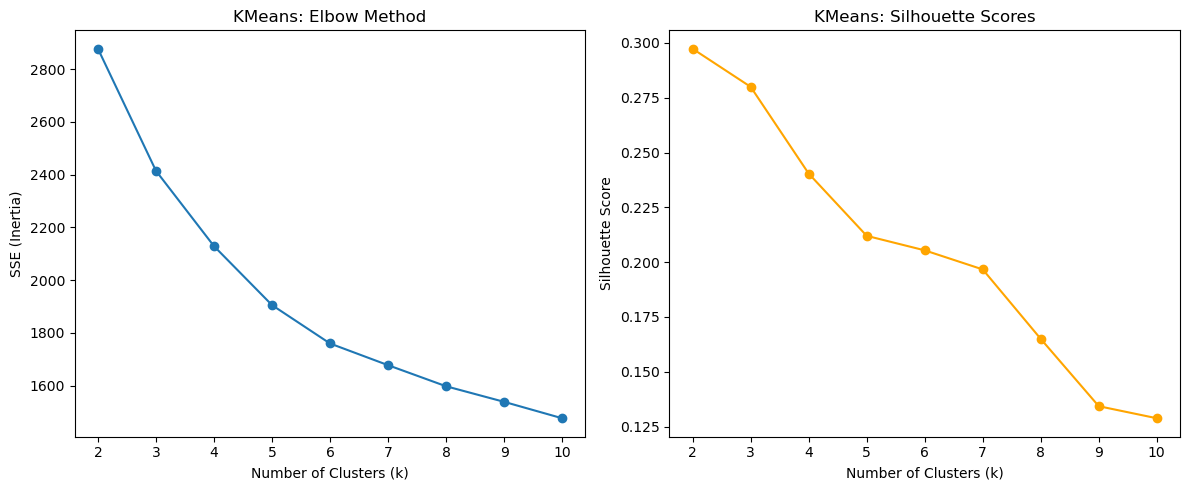

    k          SSE  Silhouette
0   2  2876.634345    0.297335
1   3  2414.112988    0.279973
2   4  2128.753870    0.240406
3   5  1905.432957    0.212013
4   6  1759.975482    0.205396
5   7  1677.814677    0.196688
6   8  1597.932229    0.164996
7   9  1538.897112    0.134300
8  10  1476.707692    0.128803


In [34]:
# Run evaluation
kmeans_metrics_medicaid = kmeans_evaluation(X_combined_medicaid, k_range=range(2,11))
print(kmeans_metrics_medicaid)

Based on the KMeans evaluation for the Medicaid subreddit using the combined TF-IDF and numeric features:

The SSE (inertia) decreases as the number of clusters k increases, showing that adding clusters reduces within-cluster variance.

The Silhouette score is highest at k = 2 (0.297), but k = 4 still maintains a relatively high score (0.280), indicating that clusters remain reasonably well-separated.

Choosing k = 4 provides a balance between interpretability and granularity, allowing us to capture additional thematic distinctions in the posts while keeping clusters meaningful. This gives more detailed insights into the discussion topics and post characteristics than a 2-cluster solution.

### KMeans

In [35]:
k_medicaid = 4
km_medicaid = KMeans(n_clusters=k_medicaid, random_state=42, n_init=10)
km_medicaid.fit(X_combined_medicaid)

# Assign cluster labels to df_medicaid
df_medicaid['cluster'] = km_medicaid.labels_
print(df_medicaid['cluster'].value_counts())

cluster
2    421
1    191
0    103
3    102
Name: count, dtype: int64


In [36]:
# Extract only TF-IDF weights (exclude numeric features)
X_tfidf_only_medicaid = tfidf_matrix_medicaid.toarray()

top_terms_medicaid = get_top_terms_per_cluster(X_tfidf_only_medicaid, km_medicaid.labels_, features_medicaid, top_n=15)

# Display top terms
for cluster, terms in top_terms_medicaid.items():
    print(f"\nCluster {cluster} top terms:")
    for term, score in terms:
        print(f"{term} ({score:.4f})")


Cluster 0 top terms:
school (0.0320)
health insurance (0.0301)
ssdi (0.0252)
mom (0.0242)
letter (0.0224)
old (0.0212)
living (0.0203)
days (0.0198)
boyfriend (0.0197)
husband (0.0192)
ny (0.0189)
child (0.0186)
week (0.0184)
covered (0.0183)
use (0.0181)

Cluster 1 top terms:
social (0.0272)
hours (0.0271)
security (0.0229)
issues (0.0226)
social security (0.0219)
information (0.0218)
letter (0.0216)
cal (0.0213)
eligibility (0.0212)
medi cal (0.0208)
medi (0.0208)
called (0.0203)
week (0.0203)
dad (0.0198)
mom (0.0196)

Cluster 2 top terms:
application (0.0208)
covered (0.0163)
im (0.0163)
nursing (0.0151)
wondering (0.0146)
renewal (0.0142)
working (0.0141)
cover (0.0137)
hello (0.0135)
process (0.0134)
mom (0.0131)
doctor (0.0131)
online (0.0130)
house (0.0130)
texas (0.0126)

Cluster 3 top terms:
right (0.0238)
mom (0.0210)
letter (0.0210)
way (0.0191)
advice (0.0187)
hospital (0.0187)
private (0.0187)
house (0.0185)
lose (0.0183)
confused (0.0183)
application (0.0178)
denied (0.

In [37]:
# Summarize numeric features
cluster_summary_medicaid = df_medicaid.groupby('cluster')[numeric_cols].agg(['mean','std','min','max'])
print(cluster_summary_medicaid)

            score                   num_comments                    \
             mean       std min max         mean       std min max   
cluster                                                              
0        0.708738  0.914277   0   3    15.941748  5.054265   9  30   
1        1.670157  1.342072   0   6     6.905759  5.714388   0  27   
2        1.467933  0.969557   0   4     3.612827  2.724619   0  10   
3        5.088235  1.194898   3   7    11.911765  7.135330   0  29   

         text_length                         word_count                      
                mean         std  min   max        mean        std min  max  
cluster                                                                      
0         518.252427  251.633008   63  1222   44.223301  21.393572   6   99  
1        1304.277487  298.170618  845  2116  111.225131  25.201015  70  177  
2         438.876485  208.874829   44   935   37.722090  18.034787   3   77  
3         704.264706  326.343770  123  16

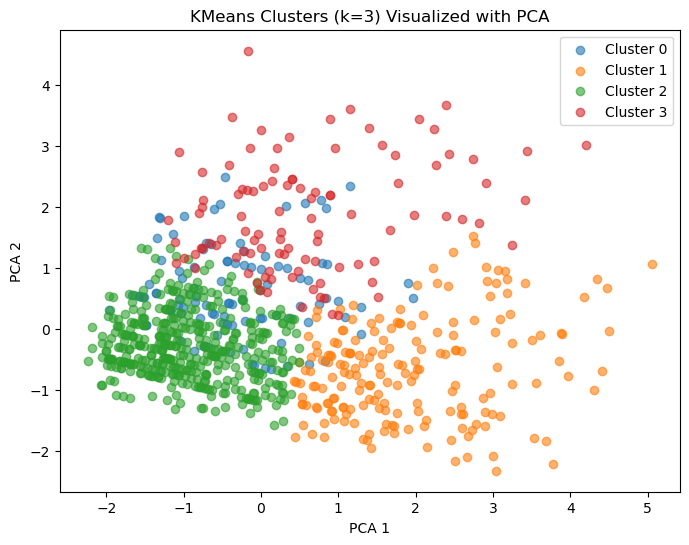

In [38]:
# Reduce TF-IDF + numeric features to 2D for visualization
pca_medicaid = PCA(n_components=2, random_state=42)
X_pca_medicaid = pca_medicaid.fit_transform(X_combined_medicaid.toarray())  # convert sparse to dense

plt.figure(figsize=(8,6))
for cluster in range(k_medicaid):
    plt.scatter(
        X_pca_medicaid[df_medicaid['cluster']==cluster, 0],
        X_pca_medicaid[df_medicaid['cluster']==cluster, 1],
        label=f'Cluster {cluster}',
        alpha=0.6
    )
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("KMeans Clusters (k=3) Visualized with PCA")
plt.legend()
plt.show()


===== Cluster 0 =====
Number of posts: 103

Top TF-IDF terms:
school (0.0320)
health insurance (0.0301)
ssdi (0.0252)
mom (0.0242)
letter (0.0224)
old (0.0212)
living (0.0203)
days (0.0198)
boyfriend (0.0197)
husband (0.0192)
ny (0.0189)
child (0.0186)
week (0.0184)
covered (0.0183)
use (0.0181)

Numeric feature summary:
            score  num_comments  text_length  word_count
count  103.000000    103.000000   103.000000  103.000000
mean     0.708738     15.941748   518.252427   44.223301
std      0.914277      5.054265   251.633008   21.393572
min      0.000000      9.000000    63.000000    6.000000
25%      0.000000     12.000000   321.000000   28.000000
50%      0.000000     15.000000   497.000000   42.000000
75%      1.000000     19.000000   700.500000   58.000000
max      3.000000     30.000000  1222.000000   99.000000


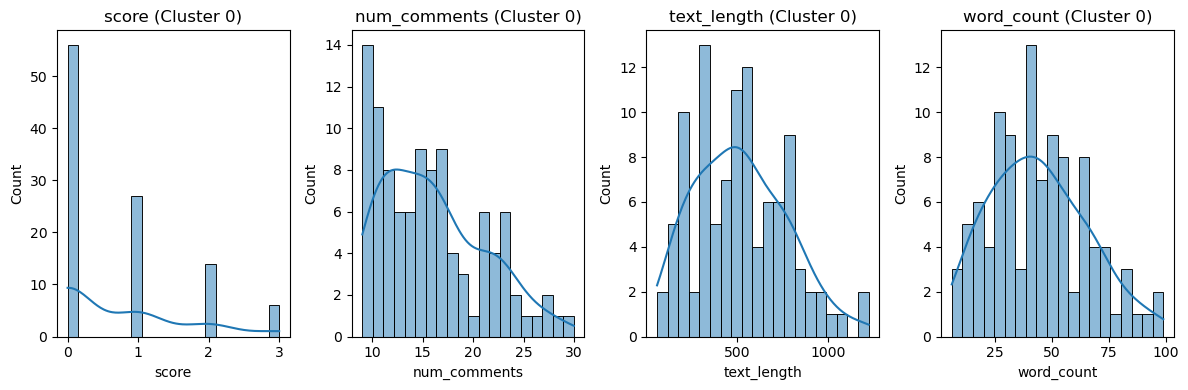


===== Cluster 1 =====
Number of posts: 191

Top TF-IDF terms:
social (0.0272)
hours (0.0271)
security (0.0229)
issues (0.0226)
social security (0.0219)
information (0.0218)
letter (0.0216)
cal (0.0213)
eligibility (0.0212)
medi cal (0.0208)
medi (0.0208)
called (0.0203)
week (0.0203)
dad (0.0198)
mom (0.0196)

Numeric feature summary:
            score  num_comments  text_length  word_count
count  191.000000    191.000000   191.000000  191.000000
mean     1.670157      6.905759  1304.277487  111.225131
std      1.342072      5.714388   298.170618   25.201015
min      0.000000      0.000000   845.000000   70.000000
25%      1.000000      2.000000  1074.000000   91.500000
50%      1.000000      5.000000  1242.000000  107.000000
75%      2.000000     10.000000  1509.500000  128.000000
max      6.000000     27.000000  2116.000000  177.000000


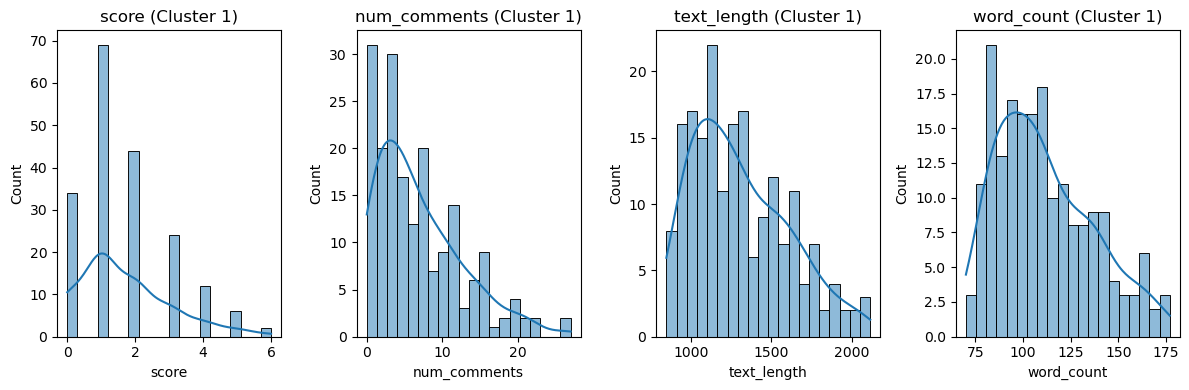


===== Cluster 2 =====
Number of posts: 421

Top TF-IDF terms:
application (0.0208)
covered (0.0163)
im (0.0163)
nursing (0.0151)
wondering (0.0146)
renewal (0.0142)
working (0.0141)
cover (0.0137)
hello (0.0135)
process (0.0134)
mom (0.0131)
doctor (0.0131)
online (0.0130)
house (0.0130)
texas (0.0126)

Numeric feature summary:
            score  num_comments  text_length  word_count
count  421.000000    421.000000   421.000000  421.000000
mean     1.467933      3.612827   438.876485   37.722090
std      0.969557      2.724619   208.874829   18.034787
min      0.000000      0.000000    44.000000    3.000000
25%      1.000000      1.000000   282.000000   23.000000
50%      1.000000      3.000000   406.000000   35.000000
75%      2.000000      5.000000   592.000000   51.000000
max      4.000000     10.000000   935.000000   77.000000


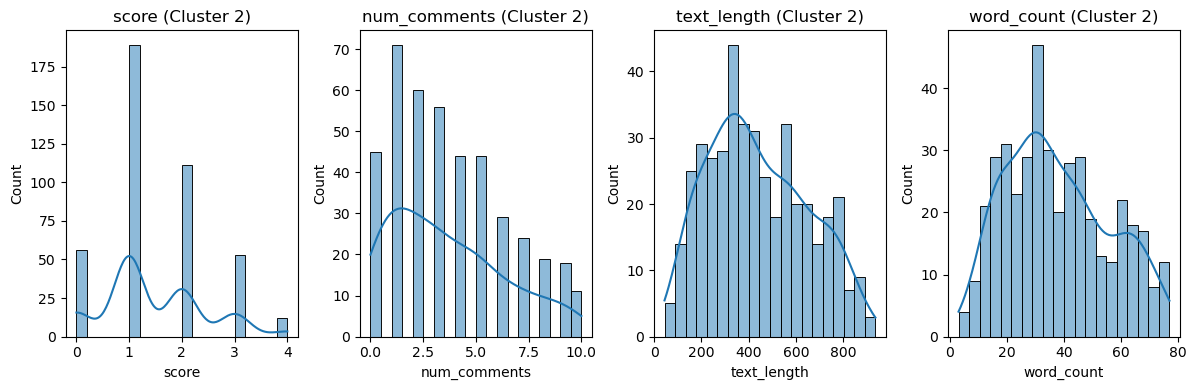


===== Cluster 3 =====
Number of posts: 102

Top TF-IDF terms:
right (0.0238)
mom (0.0210)
letter (0.0210)
way (0.0191)
advice (0.0187)
hospital (0.0187)
private (0.0187)
house (0.0185)
lose (0.0183)
confused (0.0183)
application (0.0178)
denied (0.0178)
supposed (0.0172)
changes (0.0172)
appreciated (0.0171)

Numeric feature summary:
            score  num_comments  text_length  word_count
count  102.000000    102.000000   102.000000  102.000000
mean     5.088235     11.911765   704.264706   59.862745
std      1.194898      7.135330   326.343770   28.187856
min      3.000000      0.000000   123.000000   10.000000
25%      4.000000      7.000000   465.750000   38.250000
50%      5.000000     10.000000   675.000000   55.500000
75%      6.000000     16.000000   888.750000   78.250000
max      7.000000     29.000000  1617.000000  145.000000


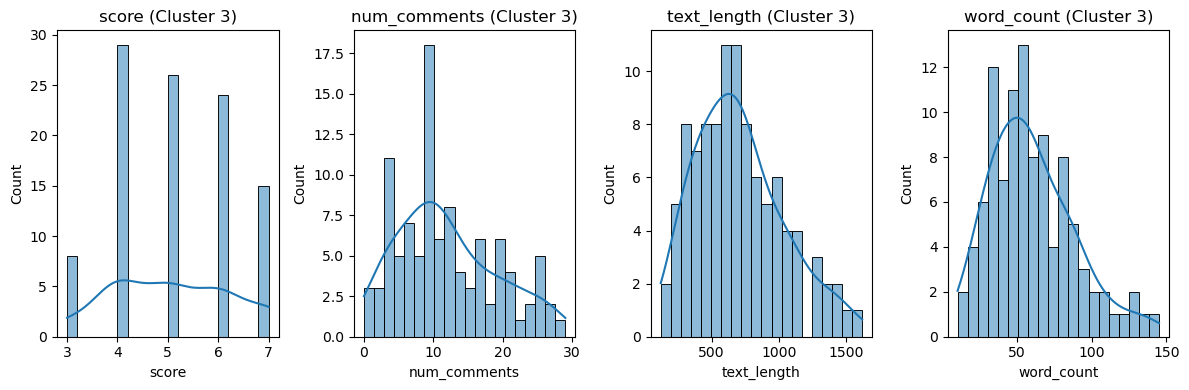

In [39]:
# Reset index to align with TF-IDF row positions
df_medicaid = df_medicaid.reset_index(drop=True)

# Run the report
cluster_info_medicaid = cluster_report(df_medicaid, X_tfidf_only_medicaid, features_medicaid, numeric_cols, top_n=15)


### Topic Modeling 

In [40]:
# Create a count matrix (LDA typically uses counts, not TF-IDF)
vectorizer_lda_medicaid = CountVectorizer(
    stop_words='english',
    min_df=10,
    max_df=0.10,
    ngram_range=(1, 2)  # include unigrams and bigrams
)

X_counts_medicaid = vectorizer_lda_medicaid.fit_transform(df_medicaid['clean_text'])
feature_names_medicaid = vectorizer_lda_medicaid.get_feature_names_out()

# Fit LDA
n_topics_medicaid = k_medicaid  # same as K in KMeans for comparison
lda_model_medicaid = LatentDirichletAllocation(
    n_components=n_topics_medicaid,
    max_iter=20,
    learning_method='batch',
    random_state=42
)

lda_model_medicaid.fit(X_counts_medicaid)

print_top_words(lda_model_medicaid, feature_names_medicaid)

# Assign topics to posts
topic_dist_medicaid = lda_model_medicaid.transform(X_counts_medicaid)
df_medicaid['lda_topic'] = topic_dist_medicaid.argmax(axis=1)

# Summary by topic
topic_summary_medicaid = df_medicaid.groupby('lda_topic').agg(
    num_posts=('clean_text', 'count'),
    avg_score=('score', 'mean'),
    avg_num_comments=('num_comments', 'mean'),
    avg_text_length=('text_length', 'mean'),
    avg_word_count=('word_count', 'mean')
).reset_index()

print(topic_summary_medicaid)

===== Topic 0 =====
cal (88.2377)
medi cal (85.2363)
medi (85.2363)
social (72.4132)
mom (67.4491)
office (66.0233)
ssi (64.4334)
called (55.2990)
case (54.0814)
security (53.4818)
information (52.0603)
social security (51.8681)
letter (51.6945)
program (50.4512)
qmb (49.2395)


===== Topic 1 =====
ago (60.8610)
son (58.7336)
child (58.2366)
parents (53.7070)
pregnant (51.2356)
mom (48.0147)
weeks (47.3102)
household (47.2570)
baby (46.2404)
days (42.6145)
denied (42.1291)
worried (41.2446)
children (40.9406)
letter (40.0751)
applied (36.7892)


===== Topic 2 =====
hours (67.1805)
doctor (64.1413)
issues (58.8142)
doctors (52.0864)
school (51.5780)
health insurance (50.0902)
cover (47.4789)
week (44.9852)
needs (42.9882)
looking (41.4829)
lot (40.2957)
providers (38.2376)
working (36.5271)
covered (34.7124)
healthcare (33.9960)


===== Topic 3 =====
nursing (88.6462)
monthly (72.4726)
mother (62.8307)
facility (62.2384)
house (60.5810)
nursing home (59.4113)
term (50.2398)
lose (48.363

### Comparison

In [41]:
# Correspondence Table
correspondence_medicaid = pd.crosstab(df_medicaid['cluster'], df_medicaid['lda_topic'], 
                             rownames=['KMeans Cluster'], colnames=['LDA Topic'])
print("\nCluster-Topic Correspondence:")
print(correspondence_medicaid)


Cluster-Topic Correspondence:
LDA Topic         0    1    2   3
KMeans Cluster                   
0                19   38   21  25
1                55   49   45  42
2               100  114  131  76
3                28   24   32  18


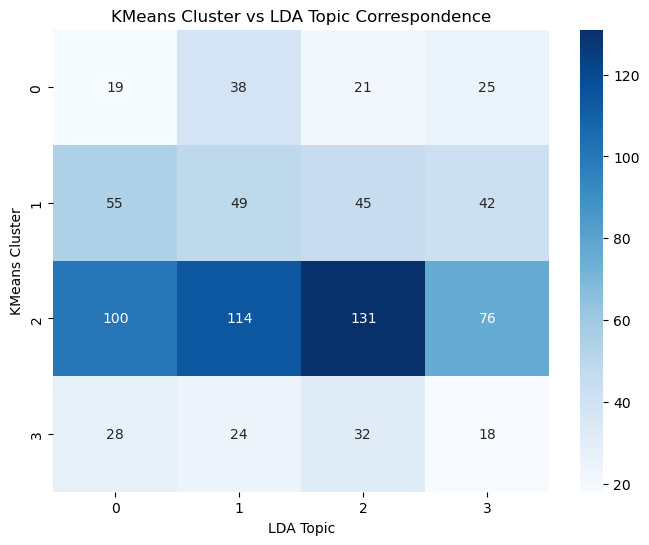

In [42]:
# Heatmap of cluster-topic correspondence
plt.figure(figsize=(8, 6))
sns.heatmap(correspondence_medicaid, annot=True, fmt='d', cmap='Blues')
plt.title("KMeans Cluster vs LDA Topic Correspondence")
plt.show()

# Medicare Subreddit

In [43]:
df_medicare = df[df['subreddit'] == 'medicare'].copy()

In [44]:
len(df_medicare)

987

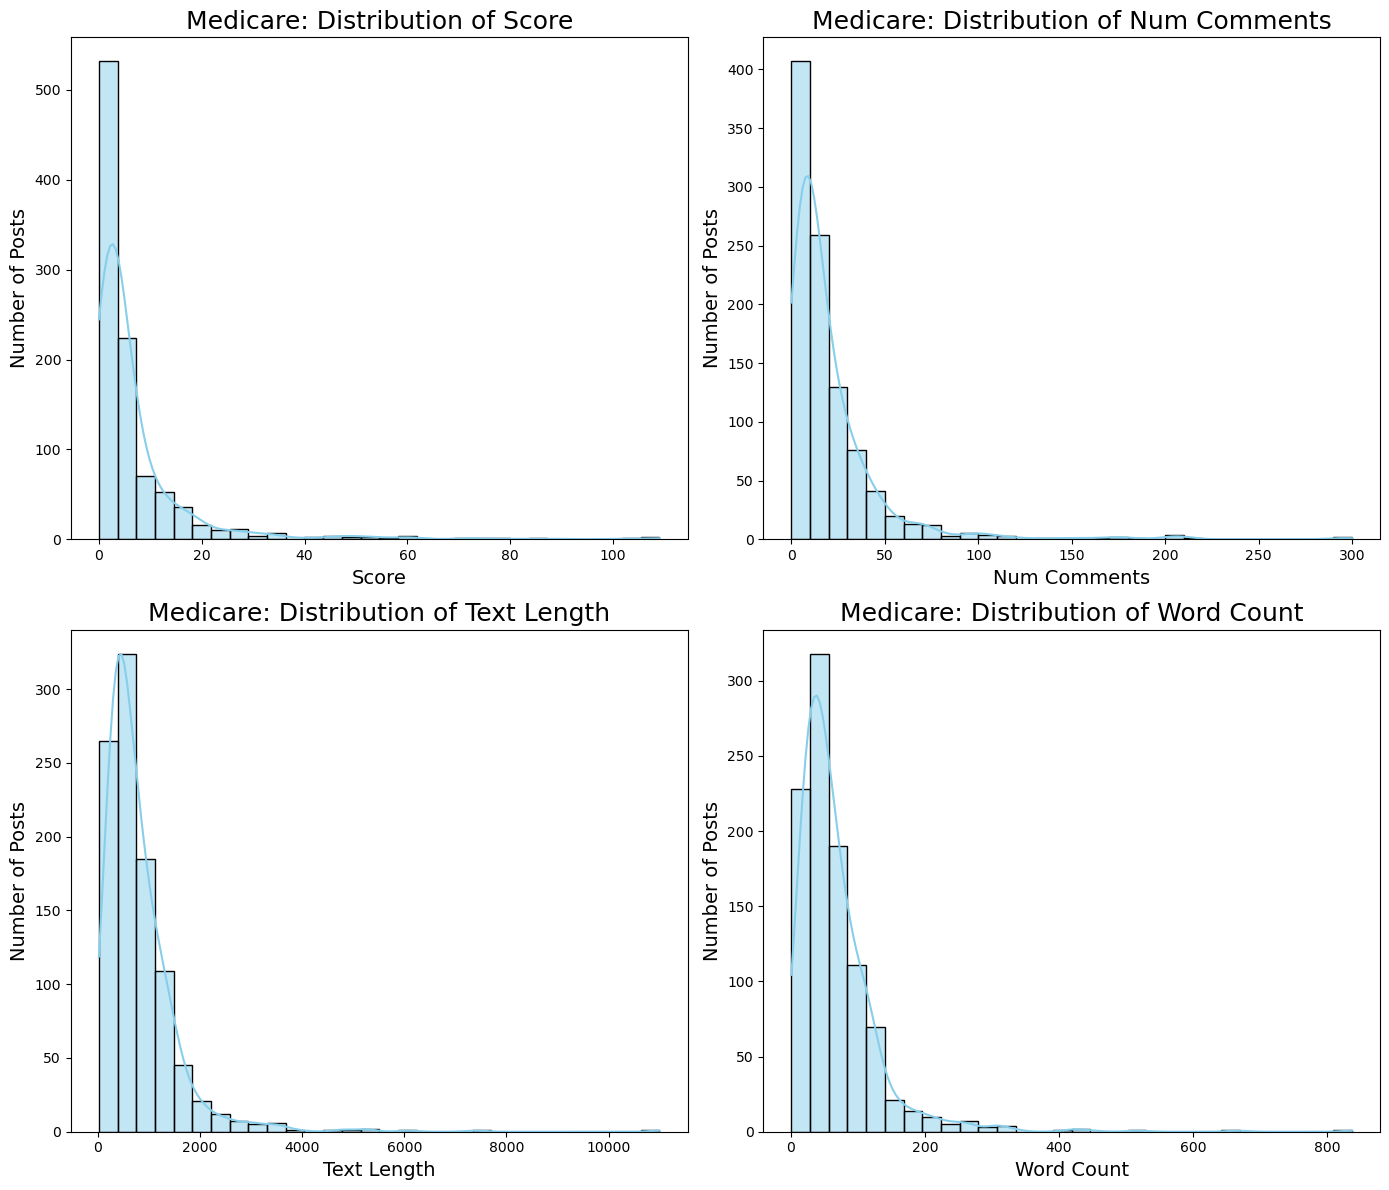

Figure saved as figures/medicare_numeric_distributions.png


In [45]:
# Example usage for Medicaid
plot_numeric_distributions(df_medicare, numeric_cols, program_name="Medicare")

## Remove Outliers

In [46]:
# Remove outliers using IQR method
df_medicare, removed_idx = remove_outliers(df_medicare, numeric_cols, method='iqr', threshold=1.5)

# Summary after removal
print(df_medicare[numeric_cols].describe())

Removed 171 outlier posts (17.33%)
            score  num_comments  text_length  word_count
count  816.000000    816.000000   816.000000  816.000000
mean     3.685049     13.349265   661.495098   55.910539
std      3.119709     10.786691   412.655634   34.915788
min      0.000000      0.000000    18.000000    1.000000
25%      1.000000      5.000000   345.000000   28.750000
50%      3.000000     10.000000   565.500000   48.000000
75%      5.000000     19.000000   919.000000   77.000000
max     14.000000     51.000000  1903.000000  165.000000


## Text Preprocessing

In [47]:
# Apply cleaning
df_medicare['clean_text'] = df_medicare['text'].apply(clean_text)

In order to determine the cutoff for `max_df` in our TF-IDF vectorizer, we will investigate the proportion of documents that each token appears in. We will set a baseline `min_df = 10` to focus on words that appear multiple times and are not too specific to a very limited number of posts

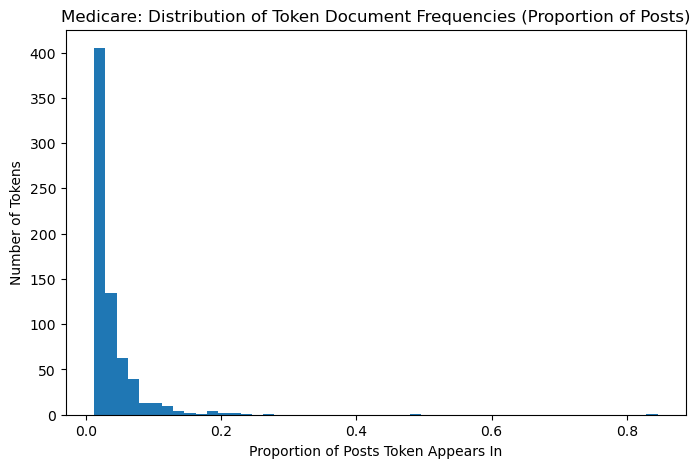

In [48]:
# Plot of token-document frequencies 
texts_medicare = df_medicare['clean_text'].tolist()

# Use CountVectorizer for raw term counts (no TF-IDF)
count_vect_medicare = CountVectorizer(stop_words='english', min_df=10)
X_counts_medicare = count_vect_medicare.fit_transform(texts_medicare)

# Compute document frequency for each token
doc_freq_medicare = (X_counts_medicare > 0).sum(axis=0).A1  # number of posts each token appears in
num_posts_medicare = len(texts_medicare)

# Convert to proportion of posts (0–1)
df_prop_medicare = doc_freq_medicare / num_posts_medicare

plt.figure(figsize=(8,5))
plt.hist(df_prop_medicare, bins=50)
plt.title("Medicare: Distribution of Token Document Frequencies (Proportion of Posts)")
plt.xlabel("Proportion of Posts Token Appears In")
plt.ylabel("Number of Tokens")
plt.show()

Based on the above plot, we will exclude all words appearing in more than 10% of posts.

In [49]:
medicare_vectorizer = TfidfVectorizer(
    stop_words='english',   # generic English stopwords
    min_df=10,              # word must appear in at least 10 posts
    max_df=0.10,            # remove words appearing in >10% of posts
    ngram_range=(1, 2),     # <-- include unigrams + bigrams
    norm='l2'               # normalize vectors
)

In [50]:
tfidf_matrix_medicare = medicare_vectorizer.fit_transform(df_medicare['clean_text'])

In [51]:
medicare_features = medicare_vectorizer.get_feature_names_out()

### Preprocessing Evaluation

In [52]:
# 3. Check preprocessing choices
print("Number of posts:", df_medicare.shape[0])
print("Number of features:", tfidf_matrix_medicare.shape[1])
print("Sample features:", medicare_features[:20])

Number of posts: 816
Number of features: 754
Sample features: ['aarp' 'aarp medicare' 'able' 'accept' 'accept medicare' 'accepts'
 'access' 'according' 'account' 'actually' 'add' 'addition' 'additional'
 'address' 'advance' 'advantage plans' 'advice' 'aetna' 'afford' 'age']


In [53]:
# Check sparsity 
medicare_sparsity = 1.0 - (tfidf_matrix_medicare.nnz / float(tfidf_matrix_medicare.shape[0] * tfidf_matrix_medicare.shape[1]))
print("Sparsity:", medicare_sparsity)

Sparsity: 0.970697131637801


In [54]:
# Examine most frequent words 
idf_medicare = medicare_vectorizer.idf_

idf_df_medicare = pd.DataFrame({'token': medicare_features, 'idf': idf_medicare})
print(idf_df_medicare.sort_values('idf').head(20))

          token       idf
547    question  3.311190
740        work  3.311190
368     looking  3.311190
396     medical  3.323612
700      trying  3.323612
214  enrollment  3.336191
470    original  3.361834
662        sure  3.388151
73     benefits  3.415180
199    eligible  3.415180
554      really  3.415180
678       thank  3.428973
184      doctor  3.442959
658  supplement  3.457144
314      income  3.471533
2          able  3.486131
714         use  3.486131
188        drug  3.500946
263         gov  3.515984
21          ago  3.531252


In [55]:
# Look at least frequent words
idf_df_medicare.sort_values('idf', ascending=False).head(20)

,token,idf
377,low income,5.307744
513,possibly,5.307744
58,automatically enrolled,5.307744
1,aarp medicare,5.307744
485,payer,5.307744
357,literally,5.307744
502,plan medicaid,5.307744
350,letter saying,5.307744
515,posted,5.307744
310,im,5.307744


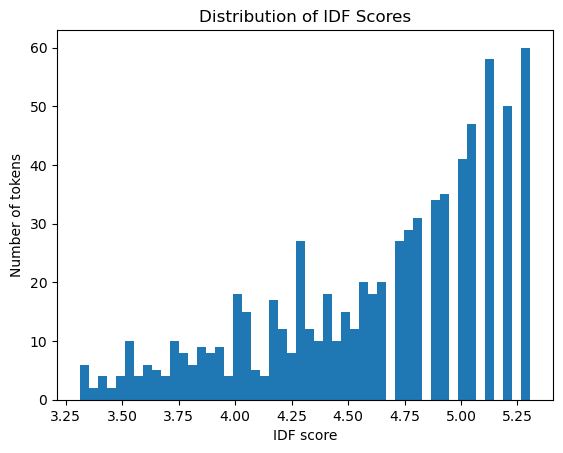

In [56]:
# IDF distribution 
plt.hist(idf_medicare, bins=50)
plt.xlabel("IDF score")
plt.ylabel("Number of tokens")
plt.title("Distribution of IDF Scores")
plt.show()

In [57]:
# Inspect bigrams from original text
medicare_counts = Counter()

# Count n-grams in original text
for text in df_medicare['clean_text']:
    tokens = text.split()
    for w in zip(tokens, tokens[1:]):
        medicare_counts[" ".join(w)] += 1

print(medicare_counts.most_common(20))

[('part b', 238), ('medicare advantage', 136), ('medicare part', 114), ('advantage plan', 103), ('original medicare', 90), ('plan g', 90), ('social security', 67), ('medicare medicaid', 67), ('medicare gov', 65), ('extra help', 58), ('medigap plan', 50), ('next year', 49), ('health insurance', 49), ('enrollment period', 38), ('advantage plans', 35), ('medicare b', 33), ('medicare supplement', 33), ('medi cal', 32), ('last year', 30), ('open enrollment', 30)]


In [58]:
# Top bigrams by document frequency 
# Boolean version of TF-IDF matrix (nonzero = term appears in doc)
tfidf_bool_medicare = (tfidf_matrix_medicare > 0).astype(int)

# Extract bigrams only
medicare_bigrams = [t for t in medicare_features if " " in t]

# Compute doc frequency
medicare_bigram_df = {}
for bg in medicare_bigrams:
    idx = medicare_vectorizer.vocabulary_.get(bg)
    medicare_bigram_df[bg] = int(tfidf_bool_medicare[:, idx].sum())

# Convert to DataFrame and sort
medicare_bigram_df = pd.DataFrame(
    sorted(medicare_bigram_df.items(), key=lambda x: x[1], reverse=True),
    columns=["bigram", "doc_freq"]
)

print(medicare_bigram_df.head(20))

                  bigram  doc_freq
0      original medicare        64
1           medicare gov        56
2      medicare medicaid        56
3        social security        50
4       health insurance        40
5             extra help        37
6           medigap plan        37
7      enrollment period        33
8    medicare supplement        31
9        advantage plans        30
10       open enrollment        29
11         medicare plan        28
12        medicare cover        26
13       supplement plan        26
14        thanks advance        26
15             drug plan        25
16            looks like        25
17             years ago        23
18         plan medicare        22
19  traditional medicare        22


In [59]:
# Documents where all TF-IDF entries are zero
medicare_empty_docs_mask = (tfidf_bool_medicare.sum(axis=1) == 0).A1

print("Number of empty docs:", medicare_empty_docs_mask.sum())

Number of empty docs: 2


In [60]:
medicare_dfreq = np.asarray(tfidf_bool_medicare.sum(axis=0)).ravel()

medicare_freq_df = pd.DataFrame({"term": medicare_features, "doc_freq": medicare_dfreq})
medicare_freq_df["type"] = np.where(medicare_freq_df["term"].str.contains(" "), "bigram", "unigram")

print(medicare_freq_df.groupby("type")["doc_freq"].describe())

         count       mean        std   min   25%   50%   75%   max
type                                                              
bigram    94.0  17.712766  10.706869  10.0  11.0  14.0  18.0  64.0
unigram  660.0  24.793939  15.383020  10.0  13.0  19.0  31.0  80.0


In [61]:
medicare_mean_tfidf = np.asarray(tfidf_matrix_medicare.mean(axis=0)).ravel()

top_mean_medicare = pd.DataFrame({
    "term": medicare_features,
    "mean_tfidf": medicare_mean_tfidf
}).sort_values("mean_tfidf", ascending=False)

print(top_mean_medicare.head(50))

                  term  mean_tfidf
188               drug    0.017786
168         deductible    0.017714
740               work    0.016140
396            medical    0.016024
470           original    0.015987
314             income    0.015600
368            looking    0.015391
214         enrollment    0.015302
658         supplement    0.015200
306             humana    0.015124
547           question    0.014496
301           hospital    0.014476
184             doctor    0.014426
471  original medicare    0.014329
126            company    0.013974
263                gov    0.013942
199           eligible    0.013840
203           employer    0.013798
700             trying    0.013658
73            benefits    0.013590
45            approved    0.013464
706                uhc    0.013174
662               sure    0.013086
538           provider    0.013061
37               apply    0.013052
405  medicare medicaid    0.013002
521           premiums    0.012910
429                m

The TF-IDF analysis for the Medicare subreddit shows a healthy and interpretable feature set. The vocabulary includes 754 terms, with 660 unigrams and 94 meaningful bigrams, many of which are domain-specific (e.g., "health insurance," "nursing home," "apply medicaid"). The TF-IDF matrix is sparsely populated (97.1%) but contains sufficient signal, with only 2 empty documents (that have been removed). Common unigrams are largely relevant to Medicaid discussions, and no severe noise is present. Given the dimensionality and quality of features, PCA is not necessary at this stage. The current TF-IDF configuration (min_df=10, max_df=0.10, including bigrams, and keeping contractions) is appropriate for clustering. The parameters were chosen based on the distribution of words and the number of features. 

## Clustering

In [62]:
# merge in numeric data with text data
medicare_scaler = StandardScaler()
X_num_scaled_medicare = scaler.fit_transform(df_medicare[numeric_cols])

In [63]:
# Ensure TF-IDF is sparse
tfidf_sparse_medicare = tfidf_matrix_medicare  # already sparse

# Convert scaled numeric features to sparse and concatenate
X_combined_medicare = hstack([tfidf_sparse_medicare, csr_matrix(X_num_scaled_medicare)])

print("Combined feature matrix shape:", X_combined_medicare.shape)

Combined feature matrix shape: (816, 758)


### Determining k

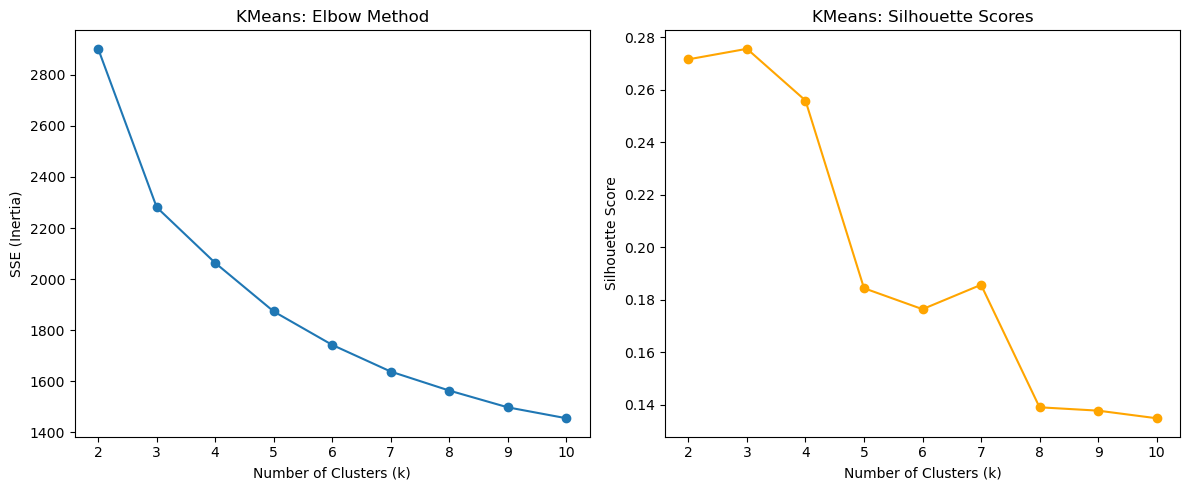

    k          SSE  Silhouette
0   2  2902.525347    0.271578
1   3  2281.198245    0.275580
2   4  2063.018989    0.255893
3   5  1872.689845    0.184437
4   6  1741.630019    0.176448
5   7  1637.116534    0.185727
6   8  1562.691941    0.139094
7   9  1496.930892    0.137820
8  10  1454.188673    0.134924


In [64]:
# Run evaluation
kmeans_metrics_medicare = kmeans_evaluation(X_combined_medicare, k_range=range(2,11))
print(kmeans_metrics_medicare)

Based on the KMeans evaluation for the Medicaid subreddit using the combined TF-IDF and numeric features:

The SSE (inertia) decreases as the number of clusters k increases, showing that adding clusters reduces within-cluster variance. 

The Silhouette score is highest at k = 3 (0.275), which corresponds to an elbow in the SSE plot.

Choosing k = 3 provides a balance between interpretability and granularity, allowing us to capture additional thematic distinctions in the posts while keeping clusters meaningful. 

### KMeans

In [65]:
k_medicare = 3
km_medicare = KMeans(n_clusters=k_medicare, random_state=42, n_init=10)
km_medicare.fit(X_combined_medicare)

# Assign cluster labels to df_medicaid
df_medicare['cluster'] = km_medicare.labels_
print(df_medicare['cluster'].value_counts())

cluster
1    425
0    217
2    174
Name: count, dtype: int64


In [66]:
# Extract only TF-IDF weights (exclude numeric features)
X_tfidf_only_medicare = tfidf_matrix_medicare.toarray()

top_terms_medicare = get_top_terms_per_cluster(X_tfidf_only_medicare, km_medicare.labels_, medicare_features, top_n=15)

# Display top terms
for cluster, terms in top_terms_medicare.items():
    print(f"\nCluster {cluster} top terms:")
    for term, score in terms:
        print(f"{term} ({score:.4f})")


Cluster 0 top terms:
doctor (0.0235)
work (0.0230)
medical (0.0211)
network (0.0205)
mom (0.0205)
income (0.0204)
question (0.0203)
issue (0.0201)
social (0.0200)
premiums (0.0199)
really (0.0198)
sure (0.0197)
security (0.0197)
original (0.0195)
think (0.0194)

Cluster 1 top terms:
humana (0.0188)
drug (0.0184)
enrollment (0.0179)
supplement (0.0172)
hospital (0.0164)
looking (0.0159)
deductible (0.0155)
medicare medicaid (0.0153)
approved (0.0151)
company (0.0148)
work (0.0145)
apply (0.0141)
uhc (0.0140)
question (0.0140)
dental (0.0139)

Cluster 2 top terms:
deductible (0.0260)
premiums (0.0216)
medigap plan (0.0209)
medical (0.0191)
gov (0.0183)
great (0.0174)
medicare gov (0.0173)
looking (0.0173)
drug (0.0171)
original (0.0168)
doctor (0.0166)
check (0.0166)
supplement (0.0164)
costs (0.0162)
paid (0.0161)


In [67]:
# Summarize numeric features
cluster_summary_medicare = df_medicare.groupby('cluster')[numeric_cols].agg(['mean','std','min','max'])
print(cluster_summary_medicare)

            score                   num_comments                     \
             mean       std min max         mean        std min max   
cluster                                                               
0        3.023041  2.310288   0  13    10.603687   7.988394   0  45   
1        2.395294  1.701547   0  10     9.237647   6.643020   0  37   
2        7.660920  3.399247   0  14    26.816092  11.265610   5  51   

         text_length                         word_count                      
                mean         std  min   max        mean        std min  max  
cluster                                                                      
0        1202.447005  268.856647  788  1903  101.649770  23.129205  67  165  
1         416.701176  200.049434   18   847   35.322353  17.045225   1   71  
2         584.775862  306.084278   46  1595   49.155172  25.531213   1  126  


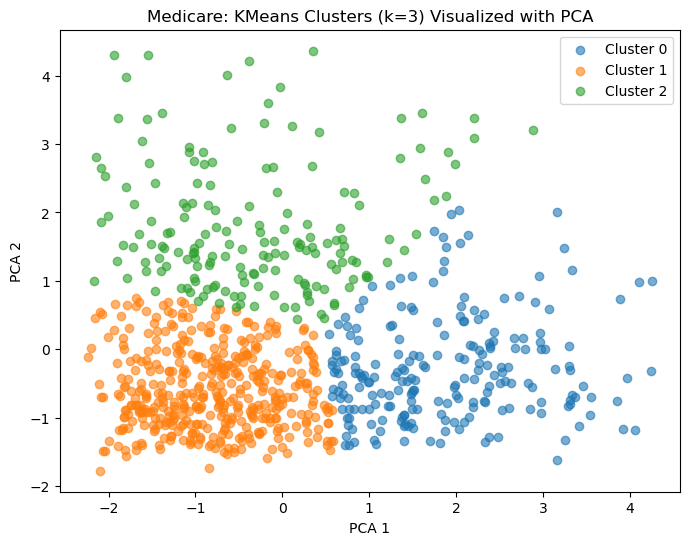

In [68]:
# Reduce TF-IDF + numeric features to 2D for visualization
pca_medicare = PCA(n_components=2, random_state=42)
X_pca_medicare = pca_medicare.fit_transform(X_combined_medicare.toarray())  # convert sparse to dense

plt.figure(figsize=(8,6))
for cluster in range(k_medicare):
    plt.scatter(
        X_pca_medicare[df_medicare['cluster']==cluster, 0],
        X_pca_medicare[df_medicare['cluster']==cluster, 1],
        label=f'Cluster {cluster}',
        alpha=0.6
    )
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("Medicare: KMeans Clusters (k=3) Visualized with PCA")
plt.legend()
plt.show()


===== Cluster 0 =====
Number of posts: 217

Top TF-IDF terms:
doctor (0.0235)
work (0.0230)
medical (0.0211)
network (0.0205)
mom (0.0205)
income (0.0204)
question (0.0203)
issue (0.0201)
social (0.0200)
premiums (0.0199)
really (0.0198)
sure (0.0197)
security (0.0197)
original (0.0195)
think (0.0194)

Numeric feature summary:
            score  num_comments  text_length  word_count
count  217.000000    217.000000   217.000000  217.000000
mean     3.023041     10.603687  1202.447005  101.649770
std      2.310288      7.988394   268.856647   23.129205
min      0.000000      0.000000   788.000000   67.000000
25%      1.000000      5.000000   963.000000   82.000000
50%      3.000000      8.000000  1176.000000  100.000000
75%      4.000000     15.000000  1377.000000  117.000000
max     13.000000     45.000000  1903.000000  165.000000


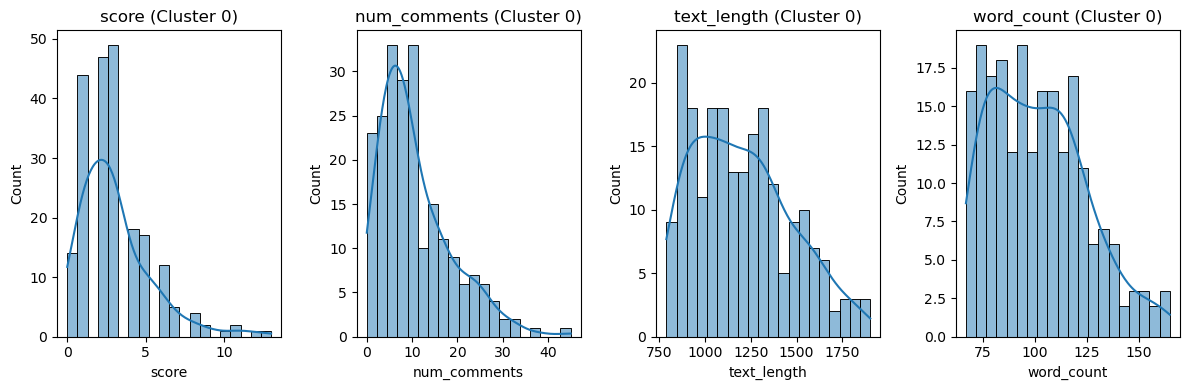


===== Cluster 1 =====
Number of posts: 425

Top TF-IDF terms:
humana (0.0188)
drug (0.0184)
enrollment (0.0179)
supplement (0.0172)
hospital (0.0164)
looking (0.0159)
deductible (0.0155)
medicare medicaid (0.0153)
approved (0.0151)
company (0.0148)
work (0.0145)
apply (0.0141)
uhc (0.0140)
question (0.0140)
dental (0.0139)

Numeric feature summary:
            score  num_comments  text_length  word_count
count  425.000000    425.000000   425.000000  425.000000
mean     2.395294      9.237647   416.701176   35.322353
std      1.701547      6.643020   200.049434   17.045225
min      0.000000      0.000000    18.000000    1.000000
25%      1.000000      4.000000   259.000000   21.000000
50%      2.000000      8.000000   418.000000   36.000000
75%      3.000000     13.000000   562.000000   48.000000
max     10.000000     37.000000   847.000000   71.000000


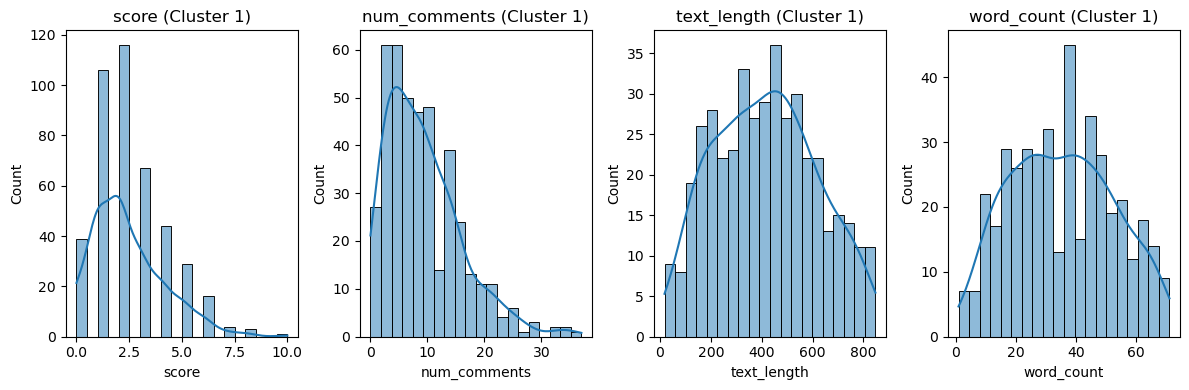


===== Cluster 2 =====
Number of posts: 174

Top TF-IDF terms:
deductible (0.0260)
premiums (0.0216)
medigap plan (0.0209)
medical (0.0191)
gov (0.0183)
great (0.0174)
medicare gov (0.0173)
looking (0.0173)
drug (0.0171)
original (0.0168)
doctor (0.0166)
check (0.0166)
supplement (0.0164)
costs (0.0162)
paid (0.0161)

Numeric feature summary:
            score  num_comments  text_length  word_count
count  174.000000    174.000000   174.000000  174.000000
mean     7.660920     26.816092   584.775862   49.155172
std      3.399247     11.265610   306.084278   25.531213
min      0.000000      5.000000    46.000000    1.000000
25%      5.000000     19.000000   357.750000   31.000000
50%      8.000000     28.000000   550.000000   46.500000
75%     10.000000     34.750000   794.750000   66.000000
max     14.000000     51.000000  1595.000000  126.000000


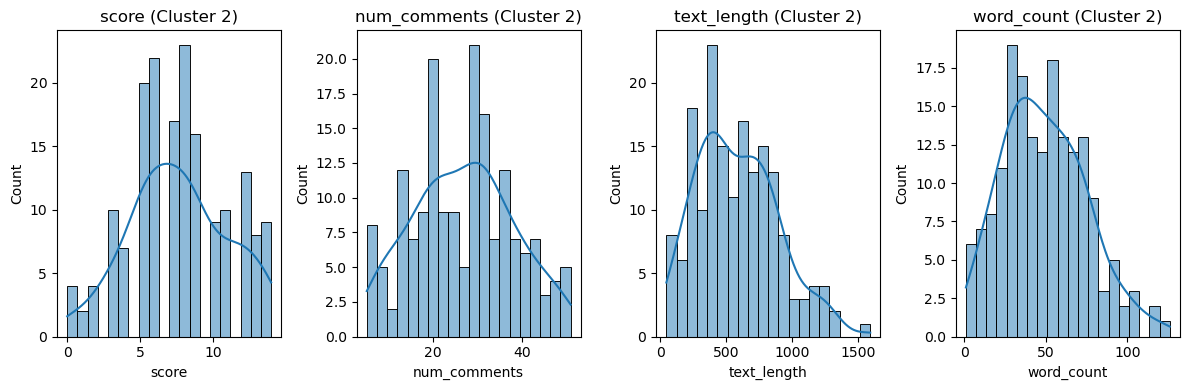

In [69]:
# Reset index to align with TF-IDF row positions
df_medicare = df_medicare.reset_index(drop=True)

# Run the report
cluster_info_medicare = cluster_report(df_medicare, X_tfidf_only_medicare, medicare_features, numeric_cols, top_n=15)


### Topic Modeling 

In [70]:
# Create a count matrix (LDA typically uses counts, not TF-IDF)
medicare_vectorizer_lda = CountVectorizer(
    stop_words='english',
    min_df=10,
    max_df=0.10,
    ngram_range=(1, 2)  # include unigrams and bigrams
)

X_counts_medicare = medicare_vectorizer_lda.fit_transform(df_medicare['clean_text'])
feature_names_medicare = medicare_vectorizer_lda.get_feature_names_out()

# Fit LDA
n_topics_medicare = k_medicare  # same as K in KMeans for comparison
lda_model_medicare = LatentDirichletAllocation(
    n_components=n_topics_medicare,
    max_iter=20,
    learning_method='batch',
    random_state=42
)

lda_model_medicare.fit(X_counts_medicare)

print_top_words(lda_model_medicare, feature_names_medicare)

# Assign topics to posts
medicare_topic_dist = lda_model_medicare.transform(X_counts_medicare)
df_medicare['lda_topic'] = medicare_topic_dist.argmax(axis=1)

# Summary by topic
medicare_topic_summary = df_medicare.groupby('lda_topic').agg(
    num_posts=('clean_text', 'count'),
    avg_score=('score', 'mean'),
    avg_num_comments=('num_comments', 'mean'),
    avg_text_length=('text_length', 'mean'),
    avg_word_count=('word_count', 'mean')
).reset_index()

print(medicare_topic_summary)

===== Topic 0 =====
deductible (118.2730)
supplement (87.2789)
gov (77.8710)
company (77.2895)
cigna (74.2681)
hospital (68.2250)
medicare gov (66.2642)
issue (65.9647)
medical (65.7125)
drugs (54.9112)
drug (53.6189)
change (53.6078)
high (53.4575)
policy (53.1023)
paid (50.0678)


===== Topic 1 =====
income (102.7036)
enrollment (89.4021)
employer (87.4007)
apply (77.2137)
social (71.3076)
security (68.3098)
social security (67.3099)
start (66.1300)
end (59.8171)
qualify (59.7760)
work (59.5076)
form (58.8412)
received (57.2437)
letter (54.4692)
date (53.3027)


===== Topic 2 =====
original (87.6874)
original medicare (79.6565)
network (78.2802)
extra (75.3553)
qmb (68.2678)
really (62.9091)
doctor (62.7086)
drug (57.9636)
extra help (56.2541)
aetna (55.7162)
medicare medicaid (53.4042)
ppo (52.3010)
dual (51.3069)
doctors (50.7530)
eligible (48.5012)


   lda_topic  num_posts  avg_score  avg_num_comments  avg_text_length  \
0          0        297   4.006734         14.912458       

### Comparison

In [71]:
# Correspondence table
medicare_correspondence = pd.crosstab(df_medicare['cluster'], df_medicare['lda_topic'], 
                             rownames=['KMeans Cluster'], colnames=['LDA Topic'])
print("\nCluster-Topic Correspondence:")
print(medicare_correspondence)


Cluster-Topic Correspondence:
LDA Topic         0    1    2
KMeans Cluster               
0                72   87   58
1               144  155  126
2                81   40   53


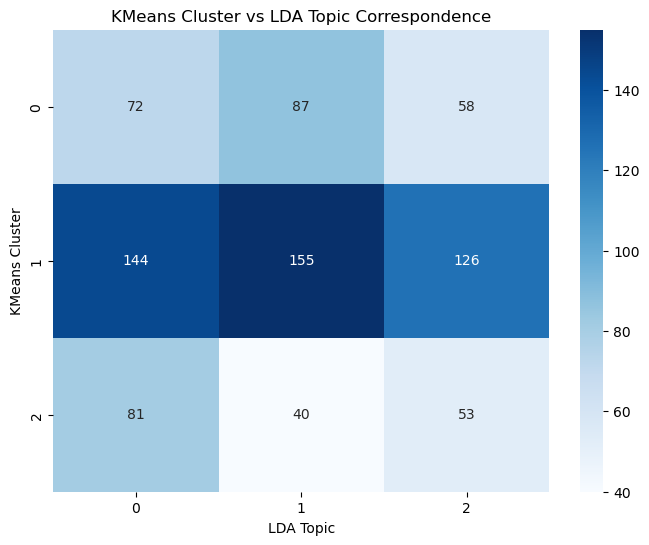

In [72]:
# Heatmap of cluster-topic correspondence
plt.figure(figsize=(8, 6))
sns.heatmap(medicare_correspondence, annot=True, fmt='d', cmap='Blues')
plt.title("KMeans Cluster vs LDA Topic Correspondence")
plt.show()

# Dashboard and Chatbot

## Prepare data for Shiny inputs

In [73]:
# EXPORT DATA FOR SHINY DASHBOARD
OUT_DIR = "shiny_data"
N_TOP_TERMS = 20
COOC_WINDOW = 5
EXAMPLES_PER_WORD = 5

os.makedirs(OUT_DIR, exist_ok=True)

# -------------------------------
# 1. Topic-term matrix (long)
# -------------------------------
topic_term_matrix_medicare = lda_model_medicare.components_
topic_term_prob_medicare = topic_term_matrix_medicare / topic_term_matrix_medicare.sum(axis=1, keepdims=True)

rows = []
for t, row in enumerate(topic_term_prob_medicare):
    for i, w in enumerate(medicare_features):
        rows.append({
            "topic": t,
            "term": w,
            "weight": float(row[i])
        })

topic_term_long_medicare = pd.DataFrame(rows)
topic_term_long_medicare.to_csv(f"{OUT_DIR}/topic_term_long.csv", index=False)

# -------------------------------
# 2. Top terms per topic (wide)
# -------------------------------
top_rows = []
for t, row in enumerate(topic_term_matrix_medicare):
    top_idx = row.argsort()[::-1][:N_TOP_TERMS]
    for rank, idx in enumerate(top_idx, start=1):
        top_rows.append({
            "topic": t,
            "rank": rank,
            "term": medicare_features[idx],
            "weight": float(row[idx])
        })

top_terms_df_medicare = pd.DataFrame(top_rows)
top_terms_df_medicare.to_csv(f"{OUT_DIR}/top_terms_by_topic.csv", index=False)

# -------------------------------------------
# 3. Document-topic probabilities + metadata
# -------------------------------------------
doc_topic_probs_medicare = pd.DataFrame(
    medicare_topic_dist,
    columns=[f"topic_{i}" for i in range(n_topics_medicare)]
)
doc_topic_probs_medicare.insert(0, "doc_id", df_medicare.index)
doc_topic_probs_medicare.to_csv(f"{OUT_DIR}/doc_topic_probs.csv", index=False)

docs_export_medicare = df_medicare.copy()
docs_export_medicare["doc_id"] = docs_export_medicare.index
docs_export_medicare.to_csv(f"{OUT_DIR}/documents.csv", index=False)

# -------------------------------
# 4. Word co-occurrence matrix
# -------------------------------
def tokenize(text):
    text = text.lower()
    text = re.sub(r'[^\w\s\']', ' ', text)
    return text.split()

cooc = Counter()

for text in df_medicare["clean_text"]:
    toks = tokenize(text)
    L = len(toks)
    for i, w in enumerate(toks):
        start = max(0, i - COOC_WINDOW)
        end = min(L, i + COOC_WINDOW + 1)
        for j in range(start, end):
            if i == j:
                continue
            pair = tuple(sorted((w, toks[j])))
            cooc[pair] += 1

cooc_rows = []
for (w1, w2), count in cooc.items():
    cooc_rows.append({"word": w1, "neighbor": w2, "count": count})

cooc_df = pd.DataFrame(cooc_rows)
cooc_df.to_csv(f"{OUT_DIR}/cooccurrence.csv", index=False)

# --------------------------------------
# 5. Example contexts for each word
# --------------------------------------
examples = defaultdict(list)

for doc_id, text in enumerate(df_medicare["text"]):
    clean = df_medicare.loc[doc_id, "clean_text"]
    toks = tokenize(clean)
    uniq = set(toks)

    for w in uniq:
        if len(examples[w]) < EXAMPLES_PER_WORD:
            snippet = text[:400]
            examples[w].append({"doc_id": doc_id, "snippet": snippet})

example_rows = []
for w, vals in examples.items():
    for v in vals:
        example_rows.append({
            "term": w,
            "doc_id": v["doc_id"],
            "example": v["snippet"]
        })

examples_df = pd.DataFrame(example_rows)
examples_df.to_csv(f"{OUT_DIR}/examples_by_word.csv", index=False)

print("✓ All data for Shiny exported to shiny_data/")


✓ All data for Shiny exported to shiny_data/


In [74]:
# ================================================================
# 6. EXPORT TF-IDF MATRIX FOR USER–DOCUMENT COSINE SIMILARITY
# ================================================================
print("Generating TF-IDF matrix...")

# ---------------------------------------------------------
# Fit TF-IDF on clean text using SAME preprocessing as LDA
# ---------------------------------------------------------
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,
    min_df=5,
    max_df=0.7,
    ngram_range=(1, 1),
    stop_words="english"
)

tfidf_matrix = tfidf_vectorizer.fit_transform(df_medicare["clean_text"])

# -----------------------------------
# Save sparse matrix for Shiny
# -----------------------------------
save_npz(f"{OUT_DIR}/tfidf_sparse.npz", tfidf_matrix)

# -----------------------------------
# Save feature names
# -----------------------------------
with open(f"{OUT_DIR}/tfidf_feature_names.json", "w") as f:
    json.dump(tfidf_vectorizer.get_feature_names_out().tolist(), f)

# -----------------------------------
# Precompute document norms (faster cosine similarity)
# -----------------------------------
doc_norms = np.sqrt(tfidf_matrix.multiply(tfidf_matrix).sum(axis=1)).A1

pd.DataFrame({
    "doc_id": df_medicare.index,
    "norm": doc_norms
}).to_csv(f"{OUT_DIR}/tfidf_doc_norms.csv", index=False)

print("✓ TF-IDF data exported for cosine similarity!")


Generating TF-IDF matrix...
✓ TF-IDF data exported for cosine similarity!


# Figures

In [75]:
# Ensure figures folder exists
os.makedirs("figures", exist_ok=True)

In [76]:
# Set plotting style
sns.set_style("whitegrid")
sns.set_context("talk")  # larger fonts

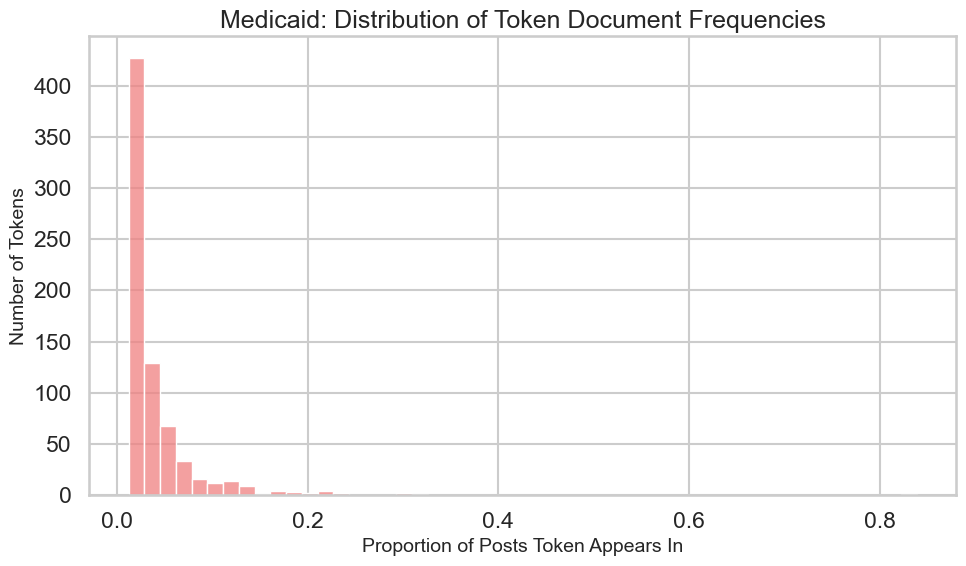

Figure saved as figures/medicaid_token_doc_freq.png


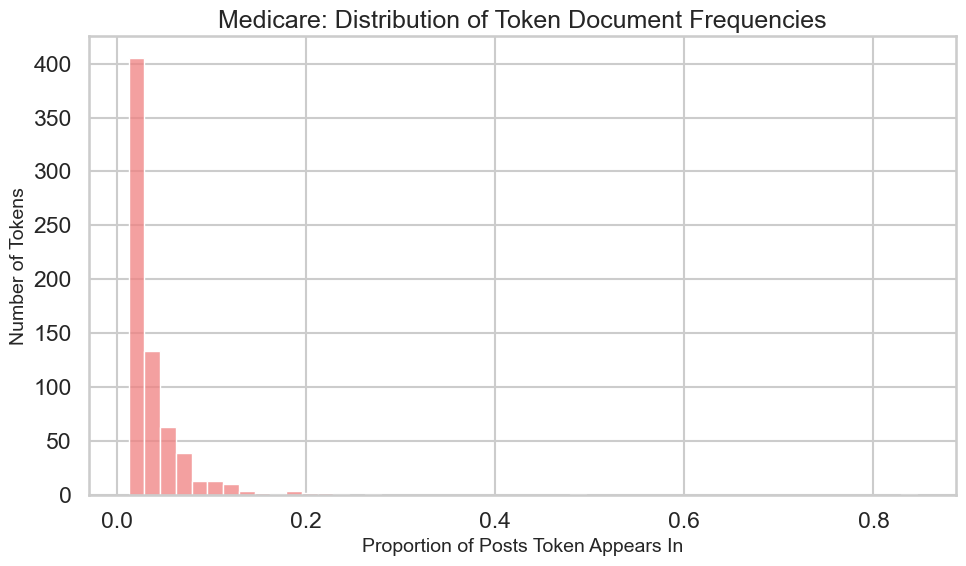

Figure saved as figures/medicare_token_doc_freq.png


In [77]:
def plot_token_doc_frequency(df, text_column="clean_text", program_name="Medicaid", min_df=10):
    """
    Plots distribution of token document frequencies for a given program.
    """
    texts = df[text_column].tolist()
    
    # CountVectorizer to get raw counts
    count_vect = CountVectorizer(stop_words='english', min_df=min_df)
    X_counts = count_vect.fit_transform(texts)
    
    # Document frequency for each token
    doc_freq = (X_counts > 0).sum(axis=0).A1  # number of posts each token appears in
    num_posts = len(texts)
    
    # Convert to proportion
    doc_freq_prop = doc_freq / num_posts
    
    # Plot
    plt.figure(figsize=(10,6))
    sns.histplot(doc_freq_prop, bins=50, color='lightcoral')
    plt.title(f"{program_name}: Distribution of Token Document Frequencies", fontsize=18)
    plt.xlabel("Proportion of Posts Token Appears In", fontsize=14)
    plt.ylabel("Number of Tokens", fontsize=14)
    plt.tight_layout()
    
    # Save figure
    filename = f"figures/{program_name.lower()}_token_doc_freq.png"
    plt.savefig(filename, dpi=300)
    plt.show()
    print(f"Figure saved as {filename}")

# Example usage
plot_token_doc_frequency(df_medicaid, text_column="clean_text", program_name="Medicaid")
plot_token_doc_frequency(df_medicare, text_column="clean_text", program_name="Medicare")


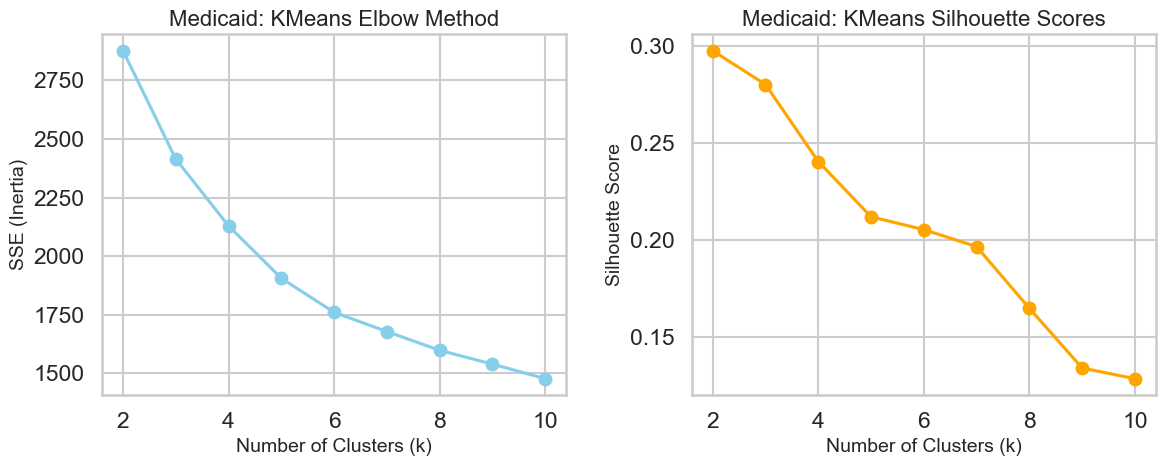

Figure saved as figures/medicaid_kmeans_eval.png


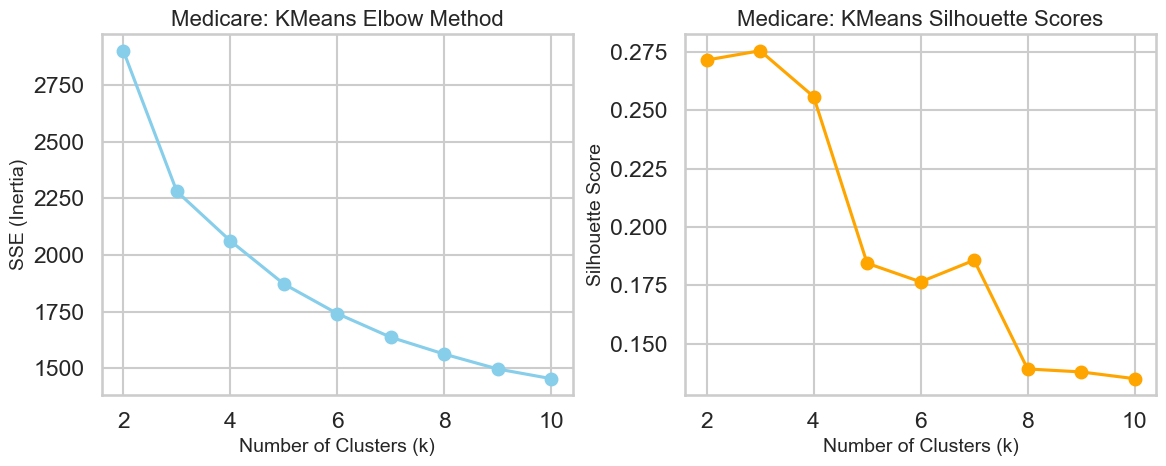

Figure saved as figures/medicare_kmeans_eval.png


In [78]:
def kmeans_elbow_silhouette(X, program_name="Medicaid", k_range=range(2,11)):
    """
    Computes KMeans SSE (inertia) and silhouette scores for a range of clusters,
    and plots both in a combined figure.
    """
    sse = []
    silhouette_scores = []

    for k in k_range:
        km = KMeans(n_clusters=k, random_state=42, n_init=10)
        km.fit(X)
        sse.append(km.inertia_)
        if k > 1:
            score = silhouette_score(X, km.labels_)
            silhouette_scores.append(score)
        else:
            silhouette_scores.append(None)
    

    plt.figure(figsize=(12,5))

    # Elbow plot
    plt.subplot(1,2,1)
    plt.plot(list(k_range), sse, marker='o', color='skyblue')
    plt.xlabel("Number of Clusters (k)", fontsize=14)
    plt.ylabel("SSE (Inertia)", fontsize=14)
    plt.title(f"{program_name}: KMeans Elbow Method", fontsize=16)

    # Silhouette plot
    plt.subplot(1,2,2)
    plt.plot(list(k_range), silhouette_scores, marker='o', color='orange')
    plt.xlabel("Number of Clusters (k)", fontsize=14)
    plt.ylabel("Silhouette Score", fontsize=14)
    plt.title(f"{program_name}: KMeans Silhouette Scores", fontsize=16)

    plt.tight_layout()
    
    # Save figure
    filename = f"figures/{program_name.lower()}_kmeans_eval.png"
    plt.savefig(filename, dpi=300)
    plt.show()
    print(f"Figure saved as {filename}")

# Example usage
# For X_combined, use your TF-IDF + numeric features matrix (sparse matrix or array)
kmeans_elbow_silhouette(X_combined_medicaid, program_name="Medicaid")
kmeans_elbow_silhouette(X_combined_medicare, program_name="Medicare")


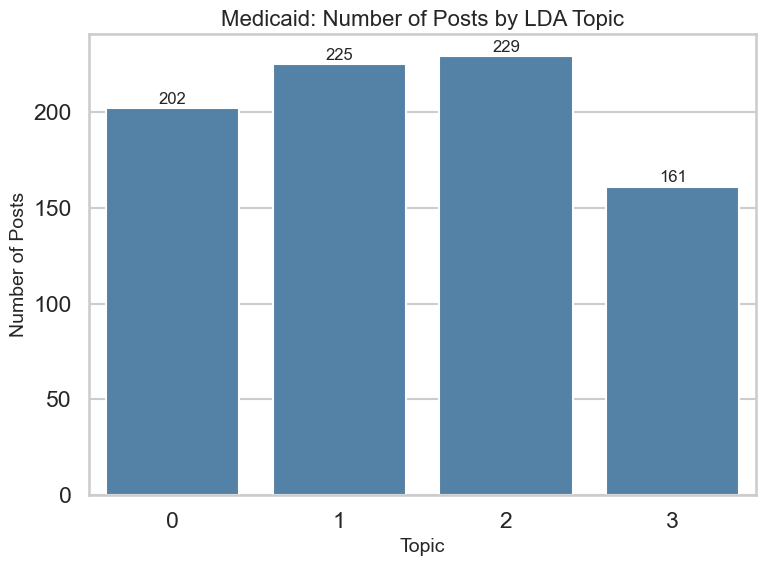

Figure saved as figures/medicaid_posts_by_topic.png


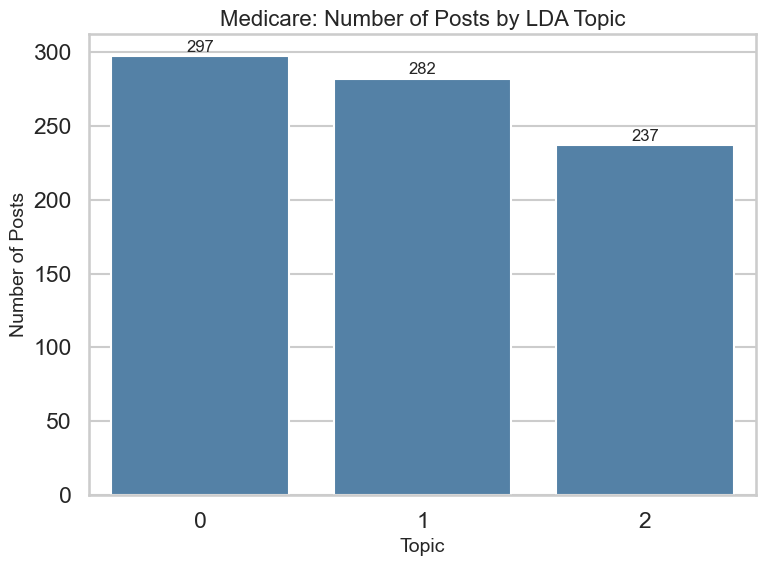

Figure saved as figures/medicare_posts_by_topic.png


In [79]:
def plot_posts_by_topic(df, topic_col='lda_topic', program_name="Medicaid"):
    """
    Plots the number of posts per LDA topic for a given program.
    """
    

    # Count posts per topic
    topic_counts = df[topic_col].value_counts().sort_index()

    plt.figure(figsize=(8,6))
    # Use 'color' instead of 'palette' to avoid the warning
    sns.barplot(x=topic_counts.index, y=topic_counts.values, color="steelblue")
    
    plt.xlabel("Topic", fontsize=14)
    plt.ylabel("Number of Posts", fontsize=14)
    plt.title(f"{program_name}: Number of Posts by LDA Topic", fontsize=16)
    
    # Annotate bars with counts
    for i, v in enumerate(topic_counts.values):
        plt.text(i, v + max(topic_counts.values)*0.01, str(v), ha='center', fontsize=12)
    
    plt.tight_layout()
    
    # Save figure
    filename = f"figures/{program_name.lower()}_posts_by_topic.png"
    plt.savefig(filename, dpi=300)
    plt.show()
    print(f"Figure saved as {filename}")

plot_posts_by_topic(df_medicaid, topic_col='lda_topic', program_name="Medicaid")
plot_posts_by_topic(df_medicare, topic_col='lda_topic', program_name="Medicare")



Top words per topic for Medicaid:

===== Topic 0 =====
cal (88.2377)
medi cal (85.2363)
medi (85.2363)
social (72.4132)
mom (67.4491)
office (66.0233)
ssi (64.4334)
called (55.2990)
case (54.0814)
security (53.4818)


===== Topic 1 =====
ago (60.8610)
son (58.7336)
child (58.2366)
parents (53.7070)
pregnant (51.2356)
mom (48.0147)
weeks (47.3102)
household (47.2570)
baby (46.2404)
days (42.6145)


===== Topic 2 =====
hours (67.1805)
doctor (64.1413)
issues (58.8142)
doctors (52.0864)
school (51.5780)
health insurance (50.0902)
cover (47.4789)
week (44.9852)
needs (42.9882)
looking (41.4829)


===== Topic 3 =====
nursing (88.6462)
monthly (72.4726)
mother (62.8307)
facility (62.2384)
house (60.5810)
nursing home (59.4113)
term (50.2398)
lose (48.3637)
report (46.2793)
long term (43.2425)


Figure saved as figures/medicaid_top_words_by_topic.png


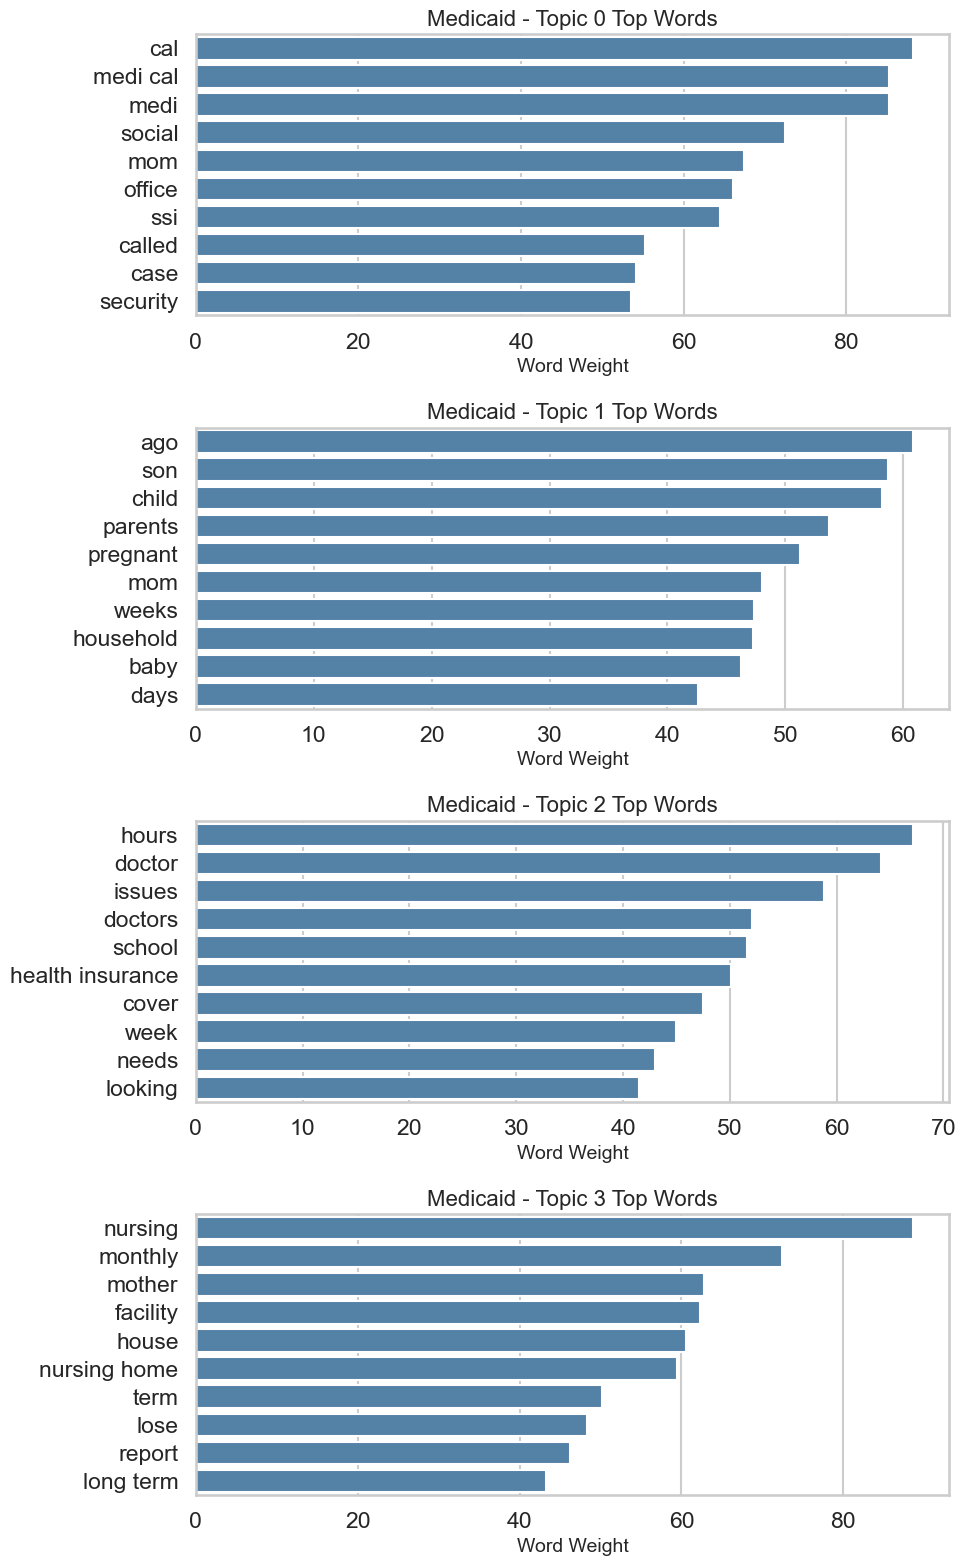


Topic summary for Medicaid:
    lda_topic  num_posts  avg_score  avg_num_comments  avg_text_length  \
0          0        202   1.925743          6.757426       712.400990   
1          1        225   1.591111          7.333333       659.671111   
2          2        229   2.052402          6.729258       636.786026   
3          3        161   1.937888          7.086957       751.204969   

   avg_word_count  
0       60.663366  
1       56.177778  
2       54.510917  
3       64.652174  

Top words per topic for Medicare:

===== Topic 0 =====
deductible (118.2730)
supplement (87.2789)
gov (77.8710)
company (77.2895)
cigna (74.2681)
hospital (68.2250)
medicare gov (66.2642)
issue (65.9647)
medical (65.7125)
drugs (54.9112)


===== Topic 1 =====
income (102.7036)
enrollment (89.4021)
employer (87.4007)
apply (77.2137)
social (71.3076)
security (68.3098)
social security (67.3099)
start (66.1300)
end (59.8171)
qualify (59.7760)


===== Topic 2 =====
original (87.6874)
original medicare 

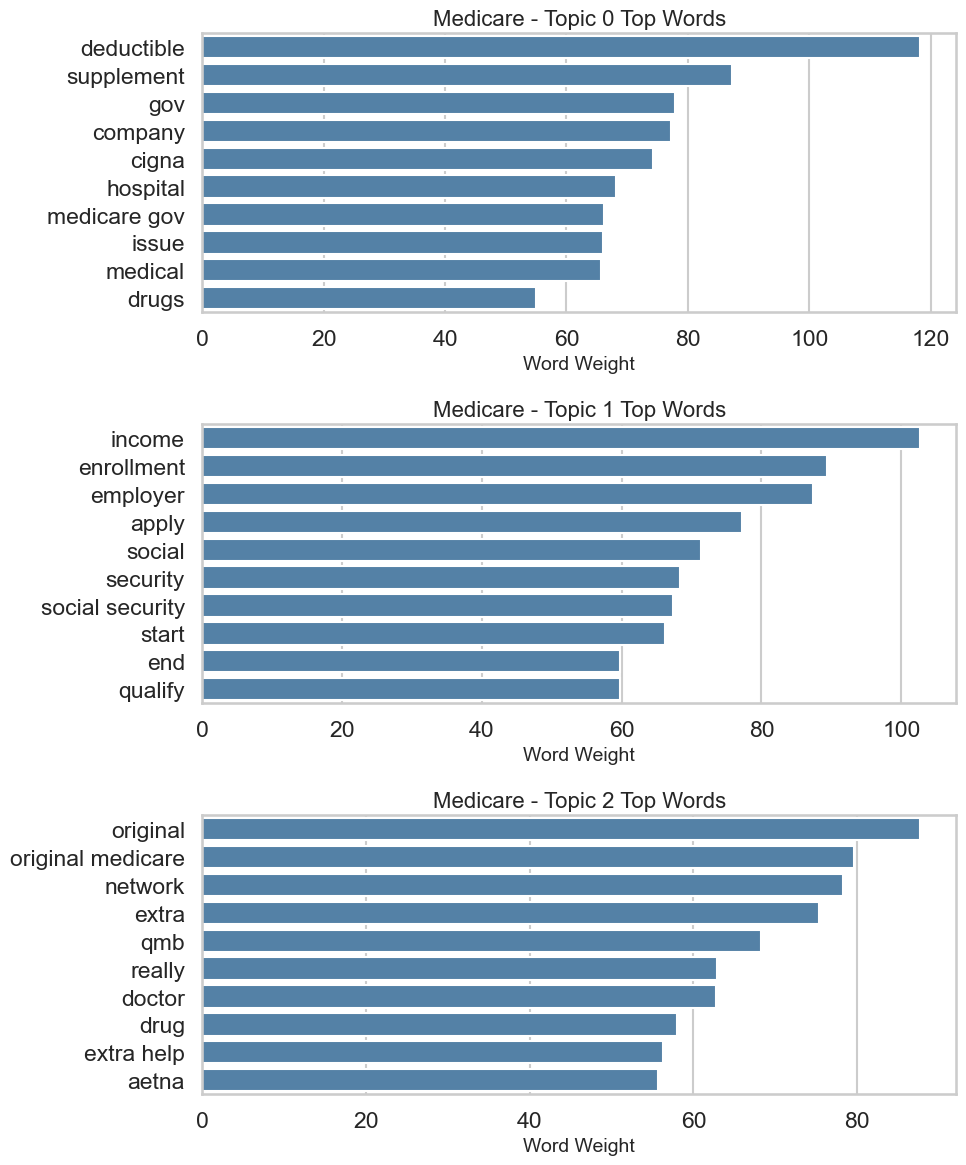


Topic summary for Medicare:
    lda_topic  num_posts  avg_score  avg_num_comments  avg_text_length  \
0          0        297   4.006734         14.912458       641.047138   
1          1        282   3.333333         11.248227       702.982270   
2          2        237   3.700422         13.890295       637.755274   

   avg_word_count  
0       53.811448  
1       59.237589  
2       54.582278  


In [80]:
def fit_lda_and_plot(df, program_name="Medicaid", n_topics=4, n_top_words=10, save=True):
    """
    Fit LDA on clean_text and plot top words per topic.

    Parameters:
        df: DataFrame containing 'clean_text' column
        program_name: 'Medicaid' or 'Medicare'
        n_topics: Number of LDA topics to fit
        n_top_words: Number of top words to plot per topic
        save: Whether to save the figure
    """
    # Step 1: Count matrix
    vectorizer_lda = CountVectorizer(
        stop_words='english',
        min_df=10,
        max_df=0.10,
        ngram_range=(1,2)
    )
    X_counts = vectorizer_lda.fit_transform(df['clean_text'])
    feature_names = vectorizer_lda.get_feature_names_out()

    # Step 2: Fit LDA
    lda_model = LatentDirichletAllocation(
        n_components=n_topics,
        max_iter=20,
        learning_method='batch',
        random_state=42
    )
    lda_model.fit(X_counts)

    # Step 3: Print top words
    print(f"\nTop words per topic for {program_name}:\n")
    for topic_idx, topic in enumerate(lda_model.components_):
        top_indices = topic.argsort()[::-1][:n_top_words]
        top_words = [feature_names[i] for i in top_indices]
        top_weights = topic[top_indices]
        print(f"===== Topic {topic_idx} =====")
        for word, weight in zip(top_words, top_weights):
            print(f"{word} ({weight:.4f})")
        print("\n")

    # Step 4: Assign topics to posts
    topic_dist = lda_model.transform(X_counts)
    df['lda_topic'] = topic_dist.argmax(axis=1)

    # Step 5: Plot top words per topic
    fig, axes = plt.subplots(n_topics, 1, figsize=(10, 4*n_topics), sharex=False)
    if n_topics == 1:
        axes = [axes]

    for topic_idx, topic in enumerate(lda_model.components_):
        top_indices = topic.argsort()[::-1][:n_top_words]
        top_words = [feature_names[i] for i in top_indices]
        top_weights = topic[top_indices]

        # Replace palette with color to remove FutureWarning
        sns.barplot(x=top_weights, y=top_words, ax=axes[topic_idx], color="steelblue")
        axes[topic_idx].set_title(f"{program_name} - Topic {topic_idx} Top Words", fontsize=16)
        axes[topic_idx].set_xlabel("Word Weight", fontsize=14)
        axes[topic_idx].set_ylabel("")

    plt.tight_layout()
    if save:
        filename = f"figures/{program_name.lower()}_top_words_by_topic.png"
        plt.savefig(filename, dpi=300)
        print(f"Figure saved as {filename}")
    plt.show()

    # Step 6: Topic summary
    topic_summary = df.groupby('lda_topic').agg(
        num_posts=('clean_text', 'count'),
        avg_score=('score', 'mean'),
        avg_num_comments=('num_comments', 'mean'),
        avg_text_length=('text_length', 'mean'),
        avg_word_count=('word_count', 'mean')
    ).reset_index()
    
    print(f"\nTopic summary for {program_name}:\n", topic_summary)
    return df, lda_model, topic_summary

# Example usage:
# Medicaid
df_medicaid, lda_medicaid, topic_summary_medicaid = fit_lda_and_plot(
    df_medicaid, program_name="Medicaid", n_topics=n_topics_medicaid, n_top_words=10
)

# Medicare
df_medicare, lda_medicare, topic_summary_medicare = fit_lda_and_plot(
    df_medicare, program_name="Medicare", n_topics=n_topics_medicare, n_top_words=10
)


Figure saved as figures/medicaid_engagement_by_topic.png


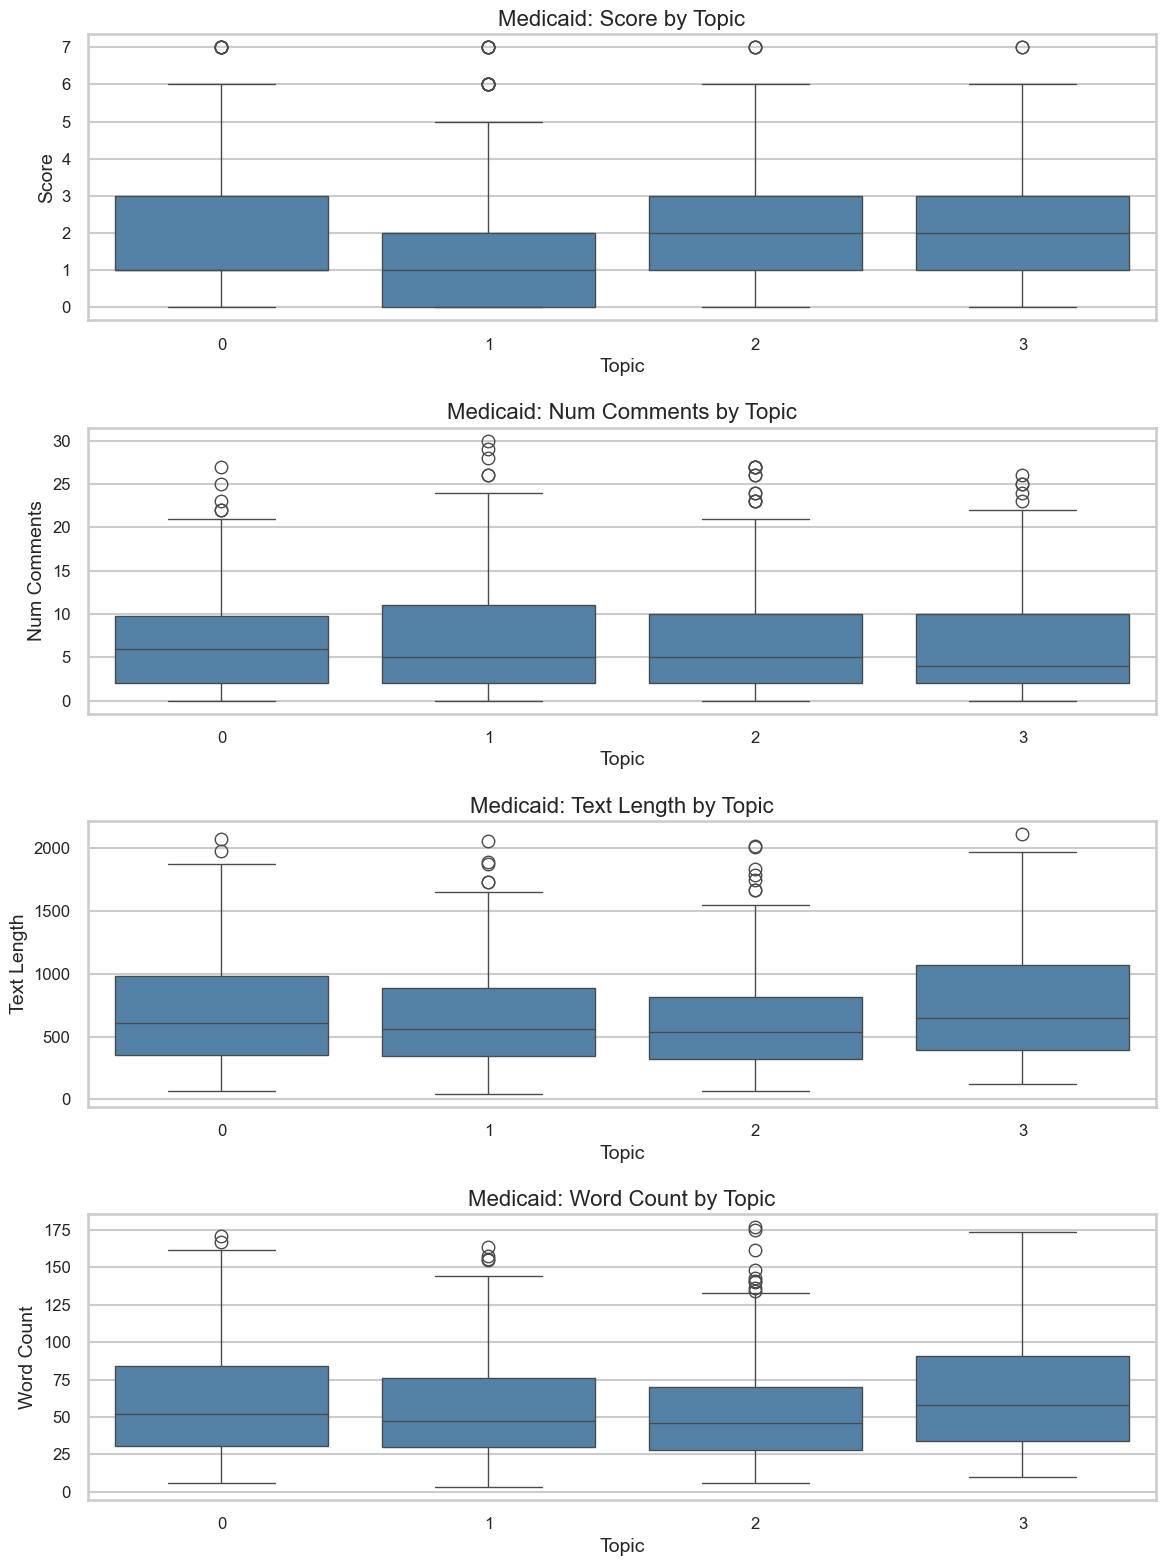

Figure saved as figures/medicare_engagement_by_topic.png


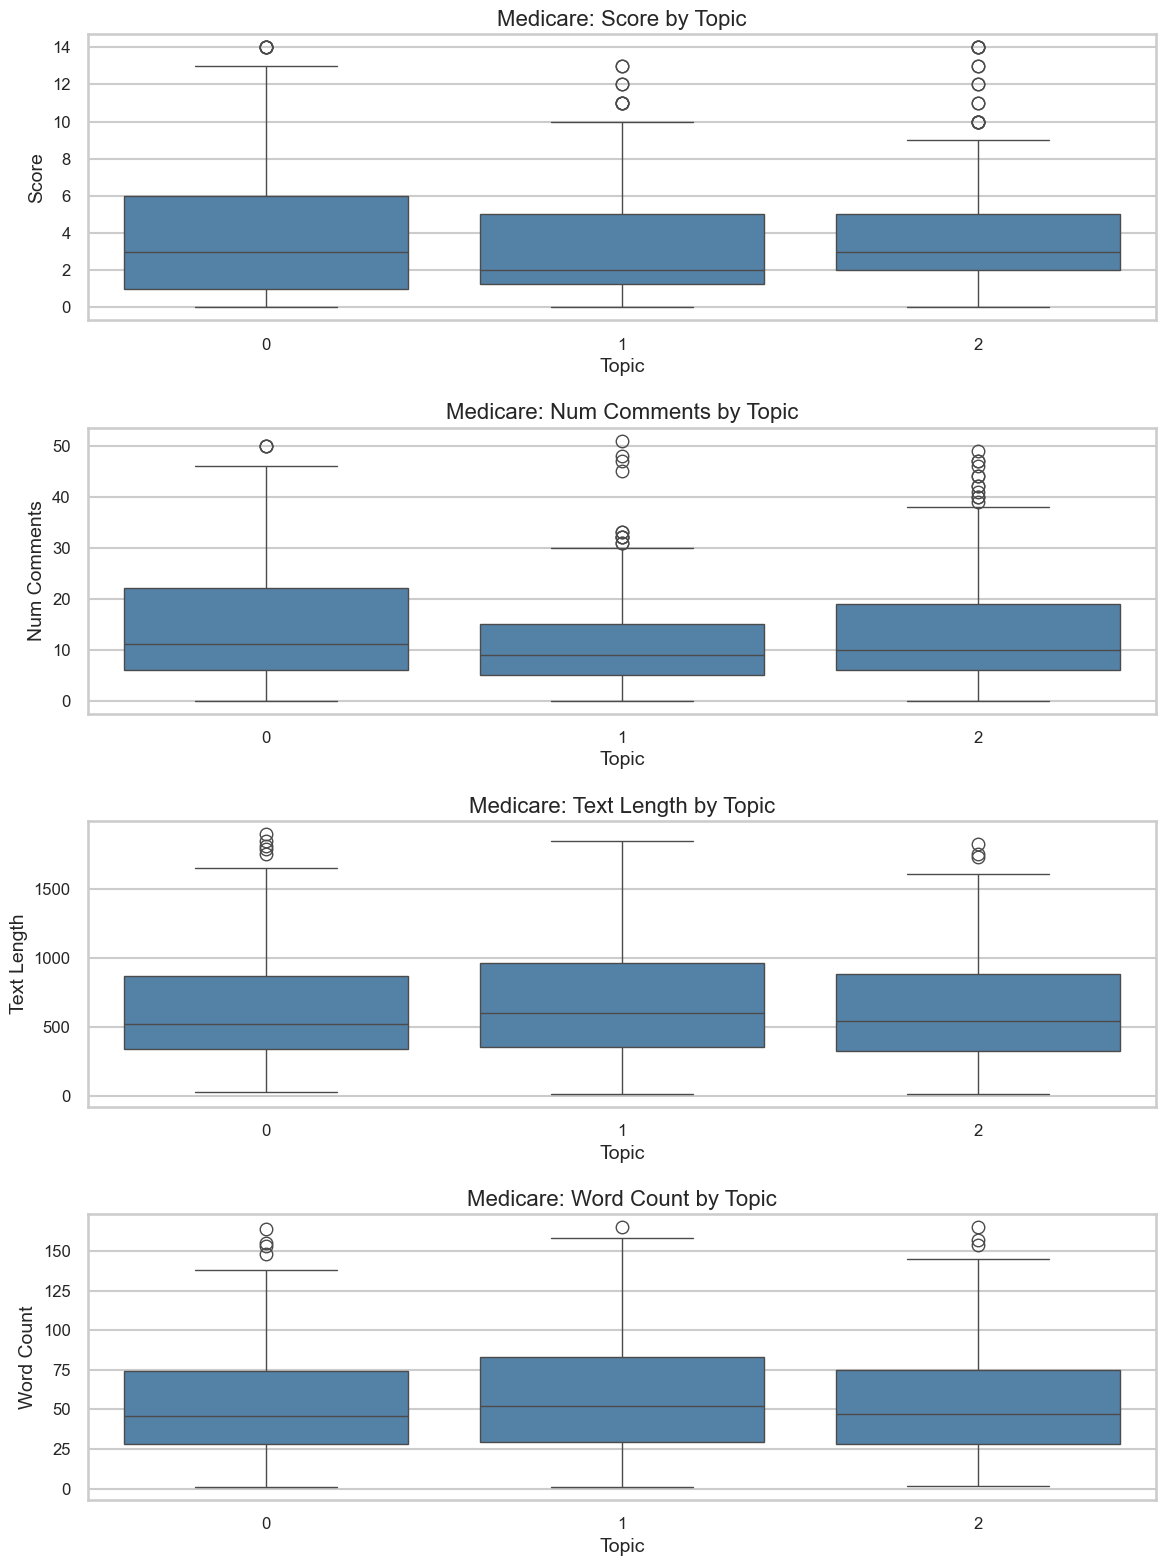

In [81]:
def plot_engagement_distributions(df, program_name="Medicaid", save=True):
    """
    Plot engagement metrics and text length distributions by LDA topic.

    Parameters:
        df: DataFrame with 'lda_topic', 'score', 'num_comments', 'text_length', 'word_count'
        program_name: 'Medicaid' or 'Medicare'
        save: Whether to save the figure
    """
    metrics = ['score', 'num_comments', 'text_length', 'word_count']
    n_metrics = len(metrics)

    # Set up figure with subplots
    fig, axes = plt.subplots(n_metrics, 1, figsize=(12, 4*n_metrics), sharex=False)

    for i, metric in enumerate(metrics):
        sns.boxplot(
            x='lda_topic',
            y=metric,
            data=df,
            color='steelblue',  # single color to avoid FutureWarning
            ax=axes[i]
        )
        axes[i].set_title(f"{program_name}: {metric.replace('_',' ').title()} by Topic", fontsize=16)
        axes[i].set_xlabel("Topic", fontsize=14)
        axes[i].set_ylabel(metric.replace('_',' ').title(), fontsize=14)
        axes[i].tick_params(axis='x', labelsize=12)
        axes[i].tick_params(axis='y', labelsize=12)

    plt.tight_layout()
    if save:
        filename = f"figures/{program_name.lower()}_engagement_by_topic.png"
        plt.savefig(filename, dpi=300)
        print(f"Figure saved as {filename}")
    plt.show()

# Example usage:
# Medicaid engagement distributions
plot_engagement_distributions(df_medicaid, program_name="Medicaid")

# Medicare engagement distributions
plot_engagement_distributions(df_medicare, program_name="Medicare")


Figure saved as figures/medicaid_kmeans_pca.png


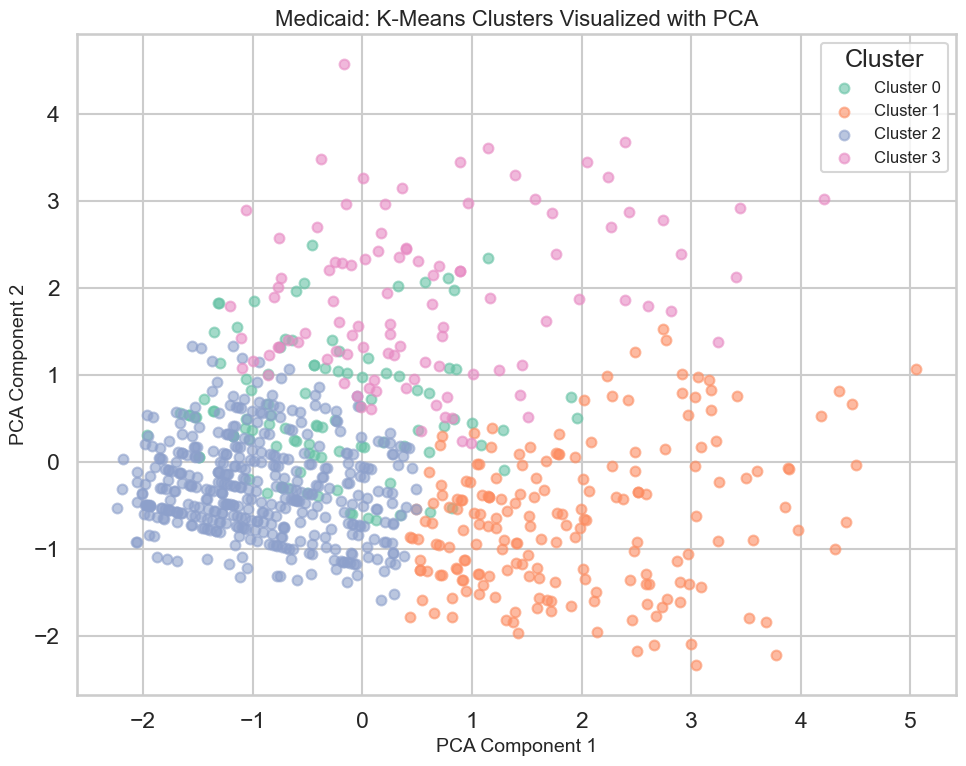

Figure saved as figures/medicare_kmeans_pca.png


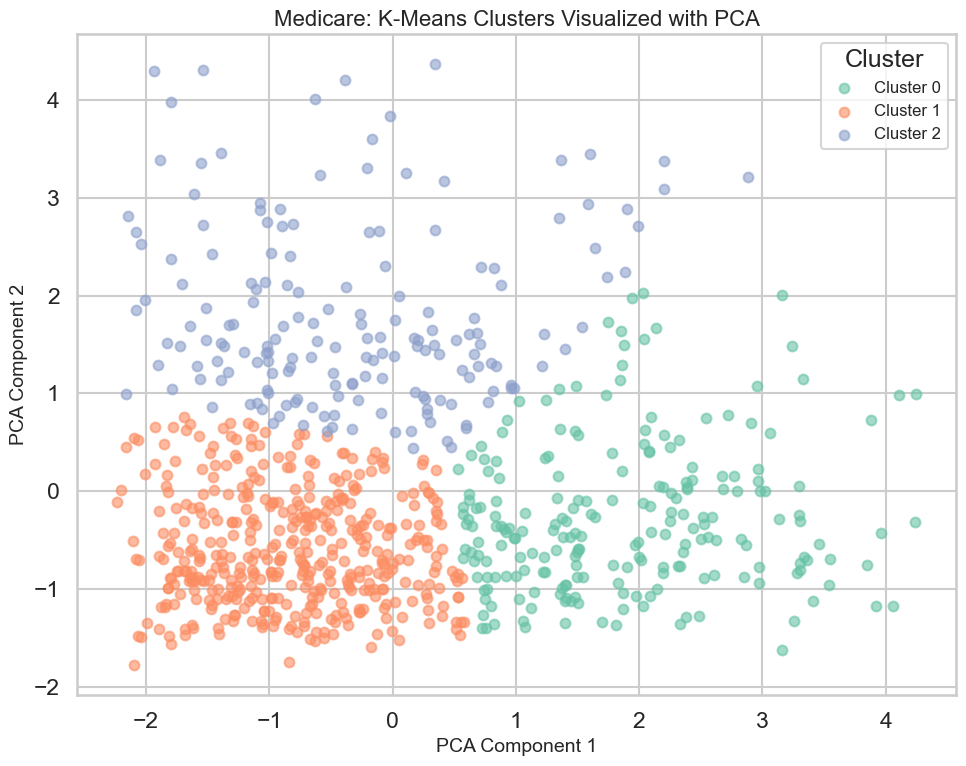

In [82]:
# Function to plot PCA clusters
def plot_kmeans_pca(X_combined, df, k, program_name="Medicaid", save=True):
    """
    Plot K-Means clusters using PCA for 2D visualization.

    Parameters:
        X_combined: TF-IDF + numeric feature matrix (dense array)
        df: DataFrame with 'cluster' column
        k: number of clusters
        program_name: 'Medicaid' or 'Medicare'
        save: whether to save figure
    """
    pca = PCA(n_components=2, random_state=42)
    X_pca = pca.fit_transform(X_combined)

    plt.figure(figsize=(10,8))
    palette = sns.color_palette("Set2", k)

    for cluster in range(k):
        idx = df['cluster'] == cluster
        plt.scatter(
            X_pca[idx, 0],
            X_pca[idx, 1],
            label=f'Cluster {cluster}',
            alpha=0.6,
            s=50,
            color=palette[cluster]
        )

    plt.xlabel("PCA Component 1", fontsize=14)
    plt.ylabel("PCA Component 2", fontsize=14)
    plt.title(f"{program_name}: K-Means Clusters Visualized with PCA", fontsize=16)
    plt.legend(title="Cluster", fontsize=12)
    plt.tight_layout()

    if save:
        filename = f"figures/{program_name.lower()}_kmeans_pca.png"
        plt.savefig(filename, dpi=300)
        print(f"Figure saved as {filename}")
    plt.show()

# Example usage:
# Medicaid
plot_kmeans_pca(X_combined_medicaid.toarray(), df_medicaid, k=k_medicaid, program_name="Medicaid")

# Medicare
plot_kmeans_pca(X_combined_medicare.toarray(), df_medicare, k=k_medicare, program_name="Medicare")

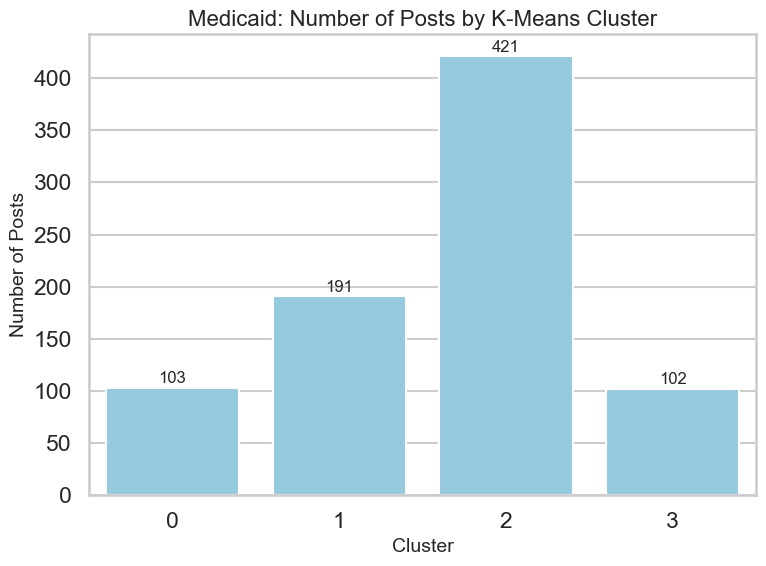

Figure saved as figures/medicaid_posts_by_cluster.png


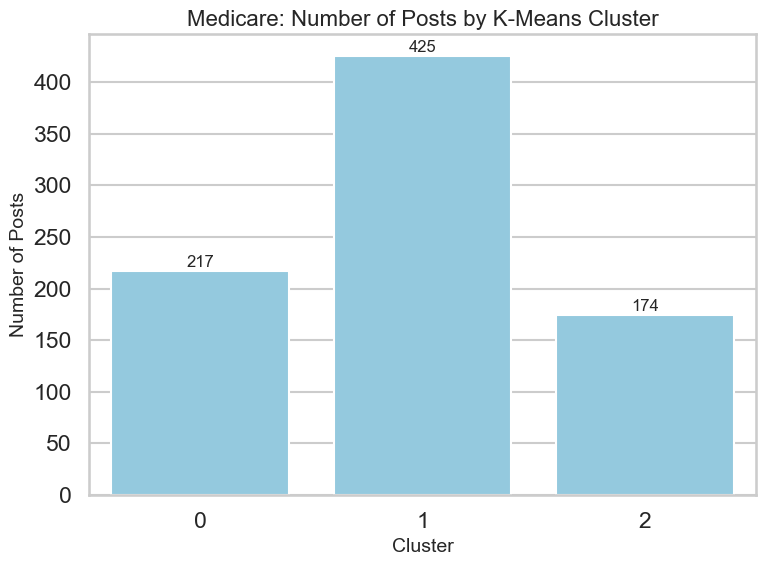

Figure saved as figures/medicare_posts_by_cluster.png


In [83]:
def plot_posts_by_cluster(df, cluster_col='cluster', program_name="Medicaid"):
    """
    Plots the number of posts per K-Means cluster for a given program.
    """
    sns.set_style("whitegrid")
    sns.set_context("talk")

    cluster_counts = df[cluster_col].value_counts().sort_index()

    plt.figure(figsize=(8,6))
    sns.barplot(x=cluster_counts.index, y=cluster_counts.values, color="skyblue", hue=None)
    plt.xlabel("Cluster", fontsize=14)
    plt.ylabel("Number of Posts", fontsize=14)
    plt.title(f"{program_name}: Number of Posts by K-Means Cluster", fontsize=16)

    # Annotate bars
    for i, v in enumerate(cluster_counts.values):
        plt.text(i, v + max(cluster_counts.values)*0.01, str(v), ha='center', fontsize=12)

    plt.tight_layout()
    filename = f"figures/{program_name.lower()}_posts_by_cluster.png"
    plt.savefig(filename, dpi=300)
    plt.show()
    print(f"Figure saved as {filename}")

# Example usage:
plot_posts_by_cluster(df_medicaid, cluster_col='cluster', program_name="Medicaid")
plot_posts_by_cluster(df_medicare, cluster_col='cluster', program_name="Medicare")


Figure saved as figures/medicaid_engagement_by_cluster.png


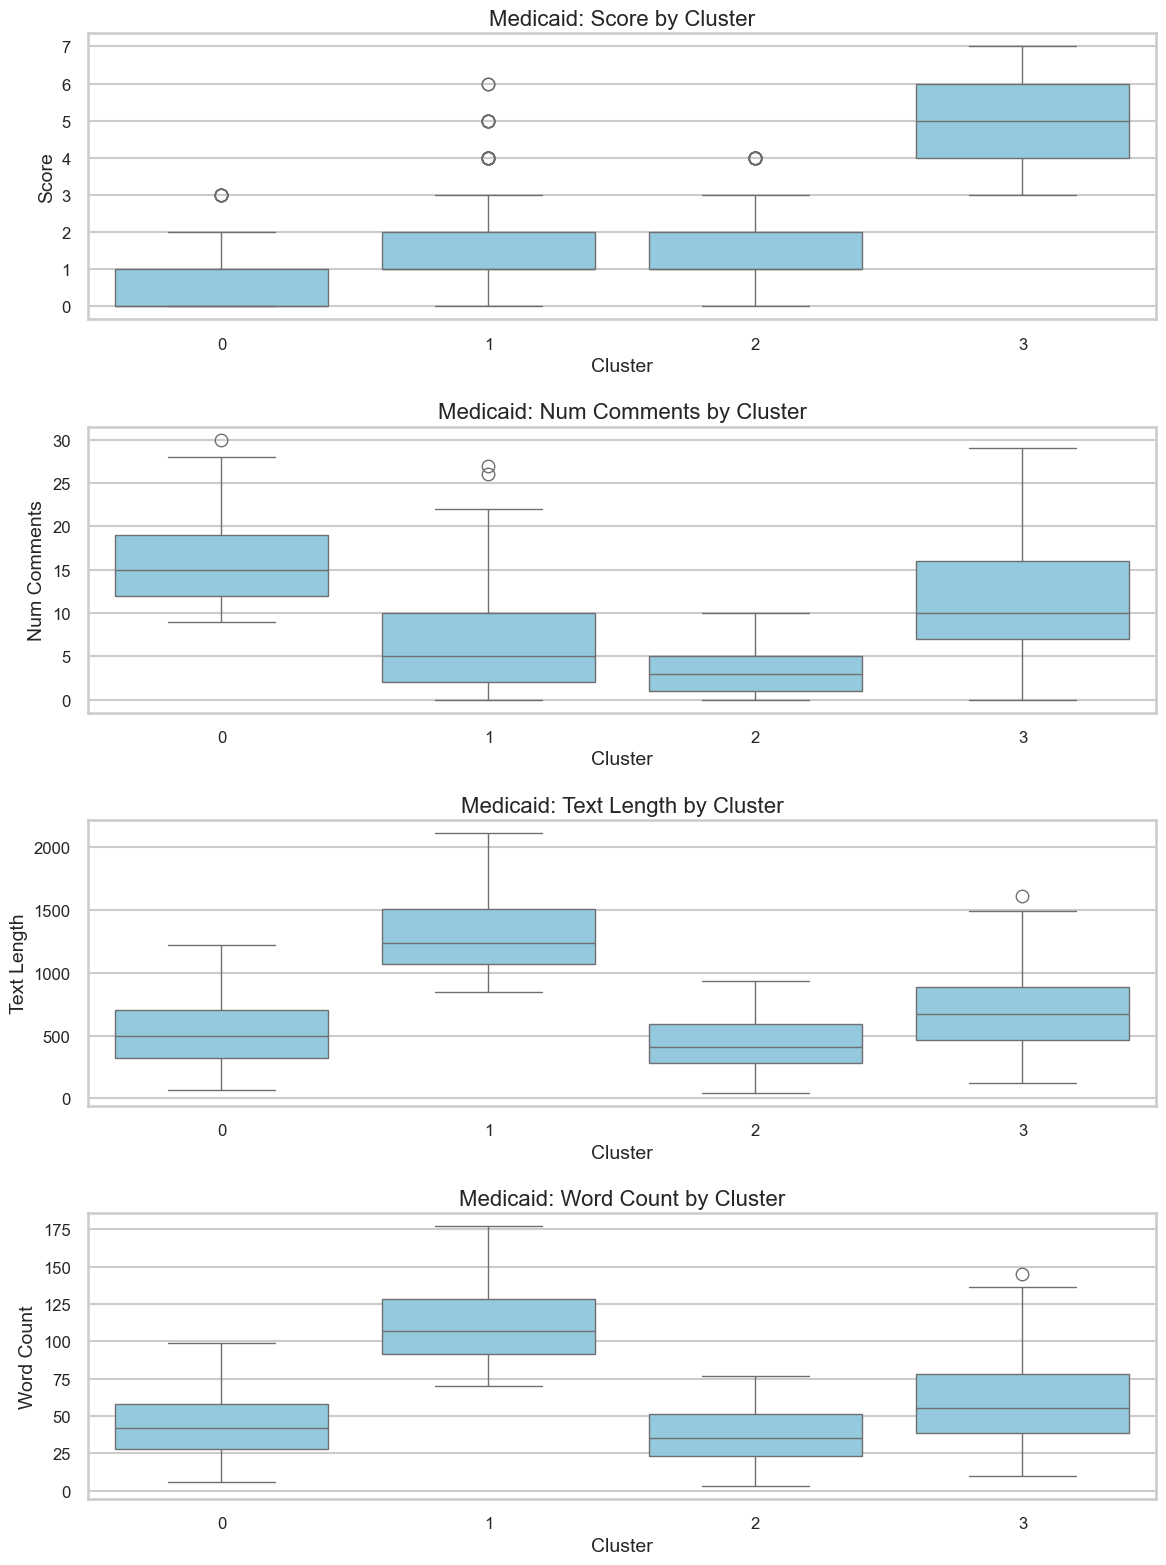

Figure saved as figures/medicare_engagement_by_cluster.png


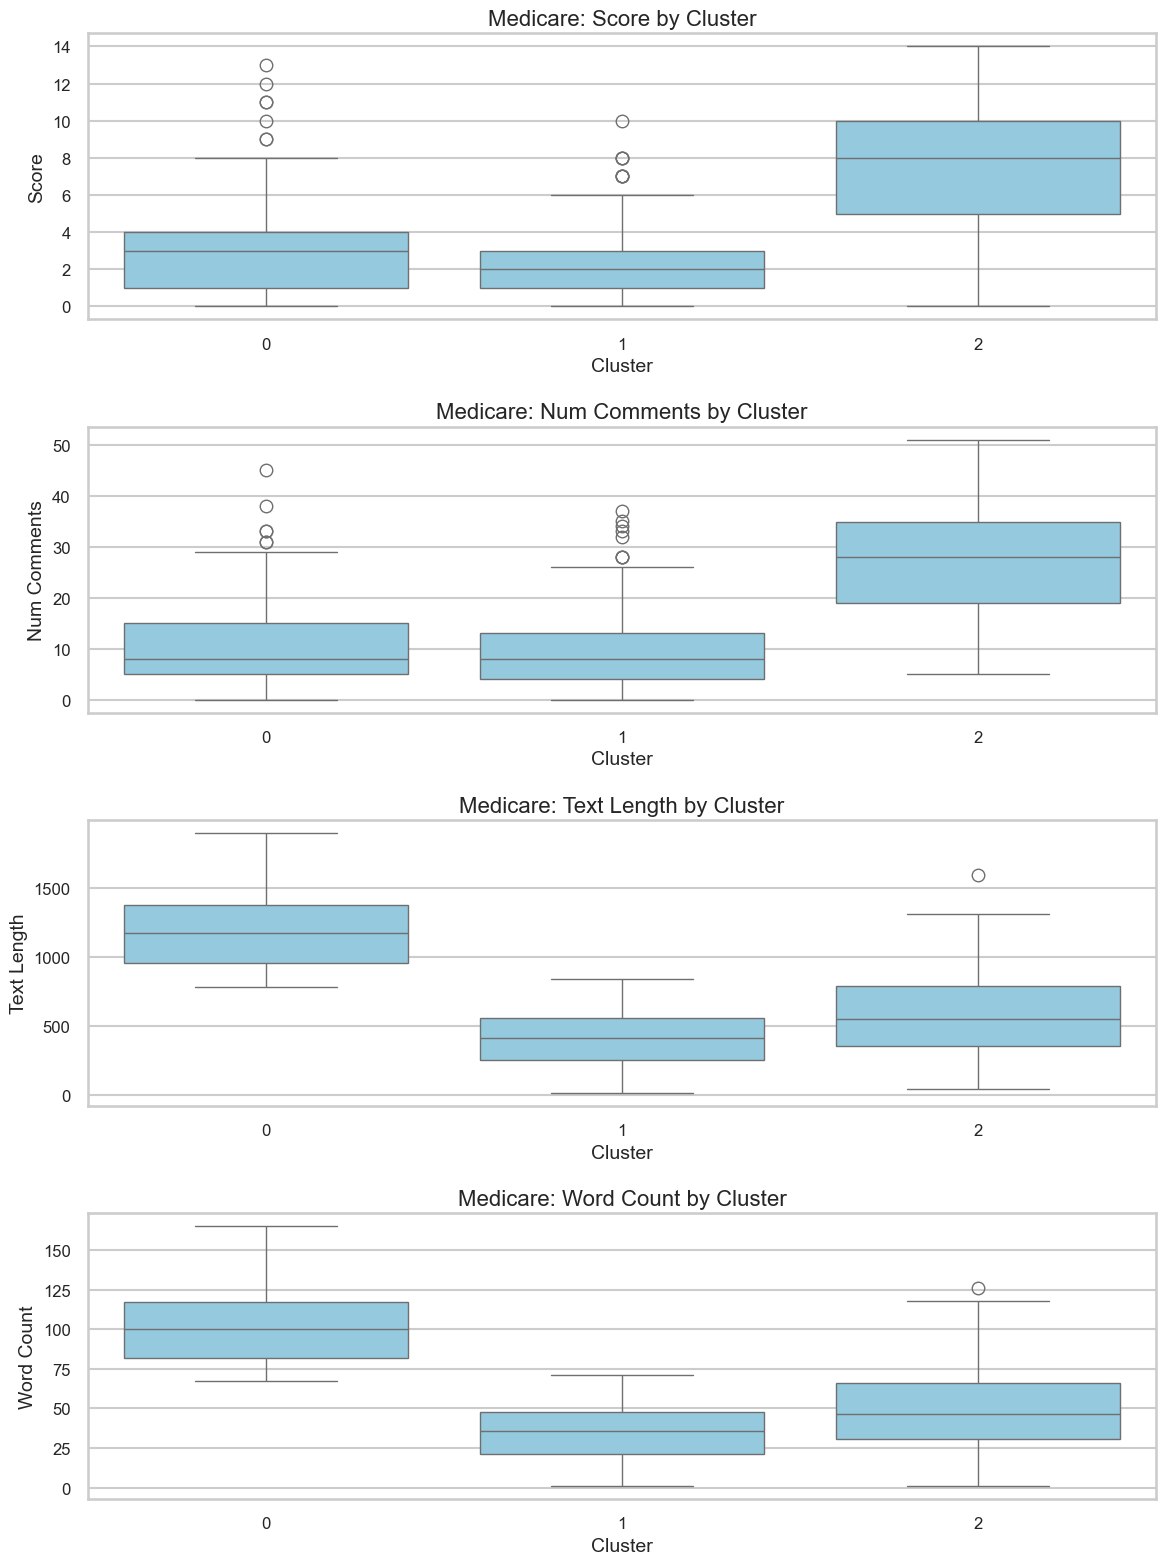

In [84]:
def plot_engagement_by_cluster(df, cluster_col='cluster', program_name="Medicaid", save=True):
    """
    Plot engagement metrics and text length distributions by K-Means cluster.
    """
    metrics = ['score', 'num_comments', 'text_length', 'word_count']
    n_metrics = len(metrics)
    n_clusters = df[cluster_col].nunique()

    fig, axes = plt.subplots(n_metrics, 1, figsize=(12, 4*n_metrics), sharex=False)

    for i, metric in enumerate(metrics):
        sns.boxplot(
            x=cluster_col,
            y=metric,
            data=df,
            color='skyblue',  # changed from palette
            ax=axes[i]
        )
        axes[i].set_title(f"{program_name}: {metric.replace('_',' ').title()} by Cluster", fontsize=16)
        axes[i].set_xlabel("Cluster", fontsize=14)
        axes[i].set_ylabel(metric.replace('_',' ').title(), fontsize=14)
        axes[i].tick_params(axis='x', labelsize=12)
        axes[i].tick_params(axis='y', labelsize=12)

    plt.tight_layout()
    if save:
        filename = f"figures/{program_name.lower()}_engagement_by_cluster.png"
        plt.savefig(filename, dpi=300)
        print(f"Figure saved as {filename}")
    plt.show()

# Example usage:
plot_engagement_by_cluster(df_medicaid, cluster_col='cluster', program_name="Medicaid")
plot_engagement_by_cluster(df_medicare, cluster_col='cluster', program_name="Medicare")

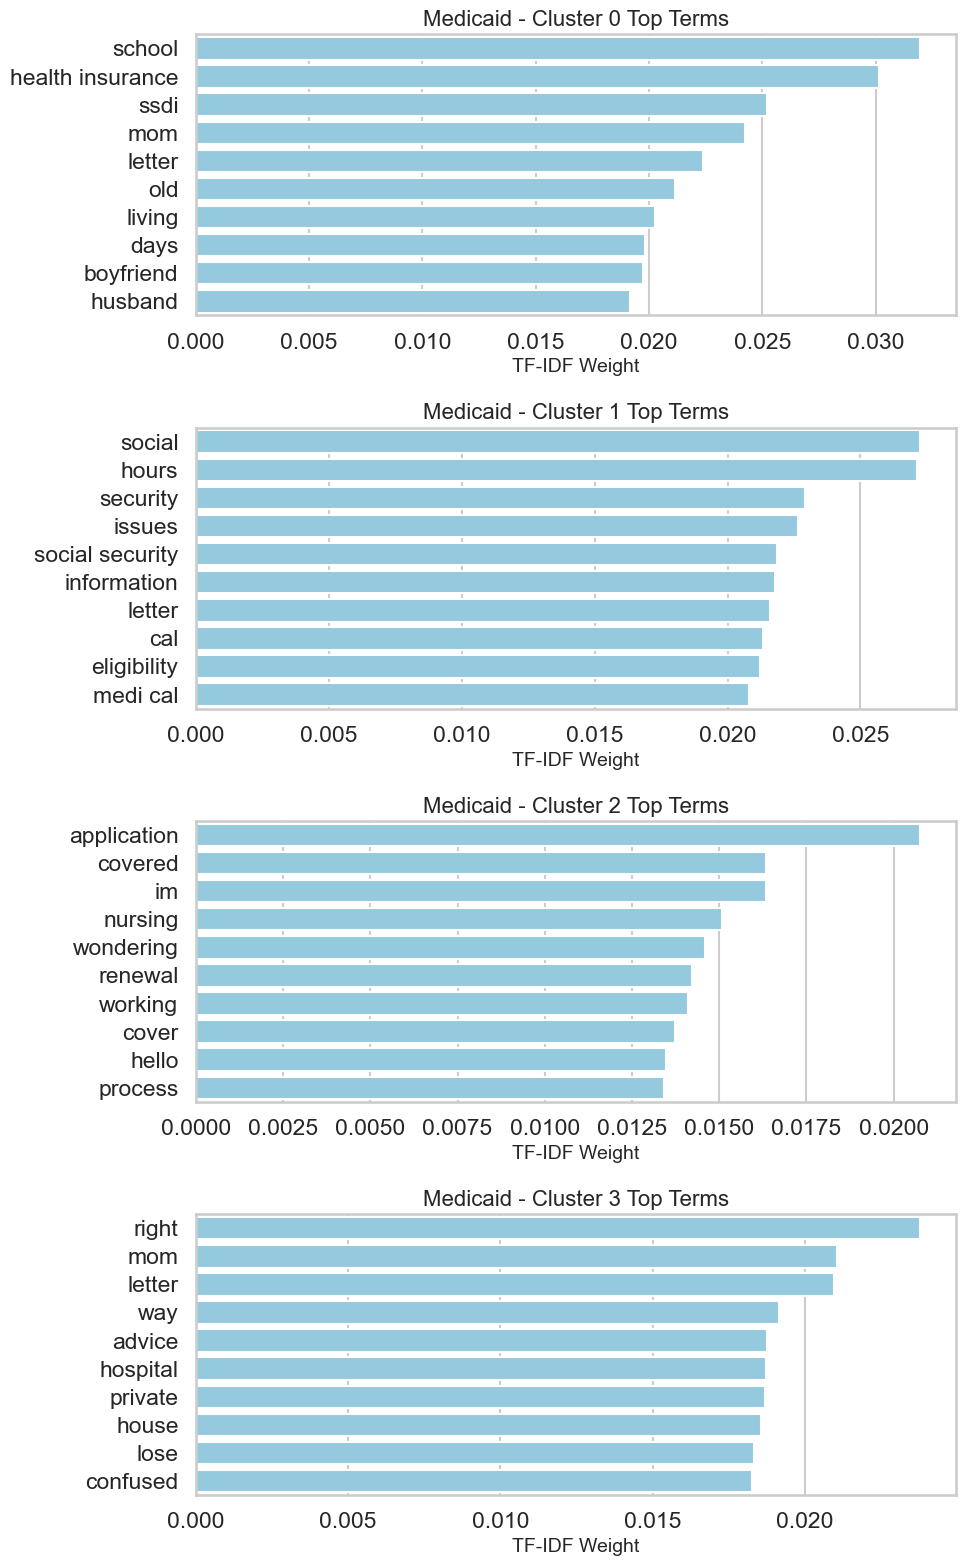

Figure saved as figures/medicaid_top_terms_by_cluster.png


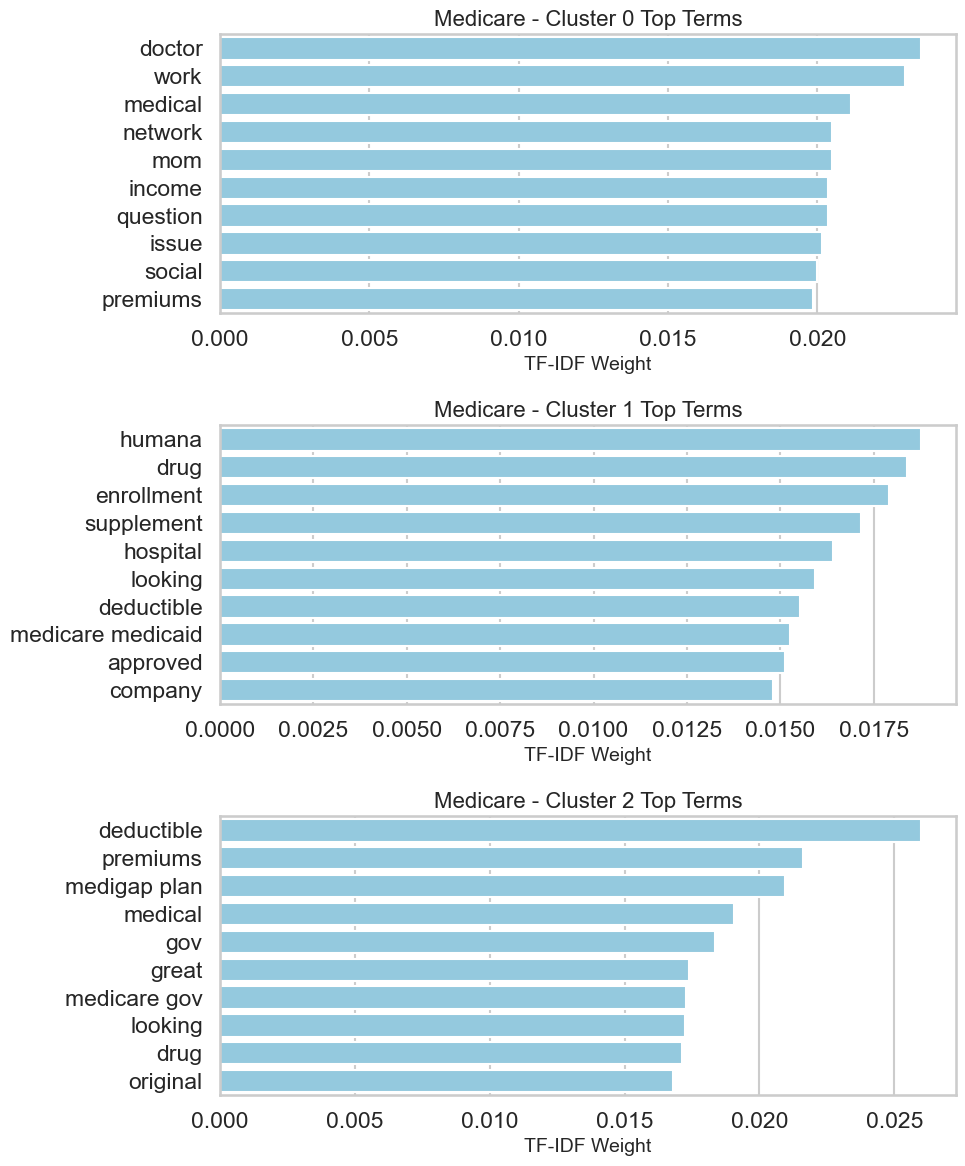

Figure saved as figures/medicare_top_terms_by_cluster.png


In [85]:
def plot_top_terms_per_cluster(df, X_tfidf, tfidf_features, numeric_features, top_n=10, program_name="Medicaid"):
    """
    Plot top TF-IDF terms per K-Means cluster.
    """
    n_clusters = df['cluster'].nunique()
    fig, axes = plt.subplots(n_clusters, 1, figsize=(10, 4*n_clusters), sharex=False)
    if n_clusters == 1:
        axes = [axes]

    for cluster in sorted(df['cluster'].unique()):
        cluster_idx = df.index[df['cluster']==cluster].tolist()
        mean_tfidf = X_tfidf[cluster_idx].mean(axis=0)
        top_idx = mean_tfidf.argsort()[::-1][:top_n]
        top_words = [tfidf_features[i] for i in top_idx]
        top_weights = mean_tfidf[top_idx]

        sns.barplot(x=top_weights, y=top_words, ax=axes[cluster], color="skyblue", hue=None)
        axes[cluster].set_title(f"{program_name} - Cluster {cluster} Top Terms", fontsize=16)
        axes[cluster].set_xlabel("TF-IDF Weight", fontsize=14)
        axes[cluster].set_ylabel("")

    plt.tight_layout()
    filename = f"figures/{program_name.lower()}_top_terms_by_cluster.png"
    plt.savefig(filename, dpi=300)
    plt.show()
    print(f"Figure saved as {filename}")


# Example usage:
plot_top_terms_per_cluster(df_medicaid, X_tfidf_only_medicaid, features_medicaid, numeric_cols, top_n=10, program_name="Medicaid")
plot_top_terms_per_cluster(df_medicare, X_tfidf_only_medicare, medicare_features, numeric_cols, top_n=10, program_name="Medicare")
